In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
sentiment_df = pd.read_csv("fear_greed_index.csv")
trades_df = pd.read_csv("historical_data.csv")

In [4]:
print("Shape of fear greed:", sentiment_df.shape)
print("Shape of trades:", trades_df.shape)

Shape of fear greed: (2644, 4)
Shape of trades: (25739, 16)


In [5]:
sentiment_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2644 entries, 0 to 2643
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   timestamp       2644 non-null   int64 
 1   value           2644 non-null   int64 
 2   classification  2644 non-null   object
 3   date            2644 non-null   object
dtypes: int64(2), object(2)
memory usage: 82.8+ KB


In [6]:
trades_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25739 entries, 0 to 25738
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Account           25739 non-null  object 
 1   Coin              25739 non-null  object 
 2   Execution Price   25739 non-null  float64
 3   Size Tokens       25739 non-null  float64
 4   Size USD          25739 non-null  float64
 5   Side              25739 non-null  object 
 6   Timestamp IST     25739 non-null  object 
 7   Start Position    25739 non-null  float64
 8   Direction         25739 non-null  object 
 9   Closed PnL        25739 non-null  float64
 10  Transaction Hash  25739 non-null  object 
 11  Order ID          25739 non-null  int64  
 12  Crossed           25739 non-null  bool   
 13  Fee               25739 non-null  float64
 14  Trade ID          25739 non-null  float64
 15  Timestamp         25739 non-null  float64
dtypes: bool(1), float64(8), int64(1), object

In [7]:
#CLEAN & PREPARE FEAR–GREED DATA

In [8]:
sentiment_df['date'] = pd.to_datetime(sentiment_df['date']).dt.strftime('%d-%m-%Y')

In [9]:
sentiment_df["classification"] = (
    sentiment_df["classification"]
    .str.strip()
    .str.lower()
)

In [10]:
sentiment_df.rename(columns={"date": "trade_date"}, inplace=True)

In [11]:
sentiment_df.head()

,timestamp,value,classification,trade_date
0,1517463000,30,fear,01-02-2018
1,1517549400,15,extreme fear,02-02-2018
2,1517635800,40,fear,03-02-2018
3,1517722200,24,extreme fear,04-02-2018
4,1517808600,11,extreme fear,05-02-2018


In [12]:
sentiment_df = sentiment_df.dropna(subset=["trade_date", "classification"])

In [13]:
sentiment_df.shape

(2644, 4)

In [14]:
#CLEAN & PREPARE TRADING DATA

In [15]:
# Convert to datetime (dayfirst=True because source is DD-MM-YYYY)
temp_ist = pd.to_datetime(trades_df['Timestamp IST'], dayfirst=True)

# Create the new separate columns
trades_df['trade_date'] = temp_ist.dt.strftime('%d-%m-%Y')
trades_df['trade_time'] = temp_ist.dt.strftime('%H:%M:%S')

# Replace: Drop the old 'Timestamp IST' column
trades_df.drop(columns=['Timestamp IST'], inplace=True)

In [16]:
# Handle Large IDs (Prevent Scientific Notation)
trades_df['Order ID'] = trades_df['Order ID'].astype(str)
# Note: Trade ID in the CSV is often a float, we convert to string to preserve it
trades_df['Trade ID'] = trades_df['Trade ID'].apply(lambda x: '{:.0f}'.format(x) if pd.notnull(x) else x)

In [17]:
trades_df.head()

,Account,Coin,Execution Price,Size Tokens,Size USD,Side,Start Position,Direction,Closed PnL,Transaction Hash,Order ID,Crossed,Fee,Trade ID,Timestamp,trade_date,trade_time
0,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9769,986.87,7872.16,BUY,0.000000,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.345404,895000000000000,1.730000e+12,02-12-2024,22:50:00
1,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9800,16.00,127.68,BUY,986.524596,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.005600,443000000000000,1.730000e+12,02-12-2024,22:50:00
2,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9855,144.09,1150.63,BUY,1002.518996,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050431,660000000000000,1.730000e+12,02-12-2024,22:50:00
3,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9874,142.98,1142.04,BUY,1146.558564,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050043,1080000000000000,1.730000e+12,02-12-2024,22:50:00
4,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9894,8.73,69.75,BUY,1289.488521,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.003055,1050000000000000,1.730000e+12,02-12-2024,22:50:00


In [18]:
# HANDLE REALIZED VS NON-REALIZED TRADES
# Remove non-realized trades (Closed PnL = 0)
performance_df = trades_df[trades_df["Closed PnL"] != 0].copy()

In [19]:
performance_df["Direction"].value_counts()

Direction
Close Long           6470
Close Short          3551
Sell                 1006
Auto-Deleveraging       8
Long > Short            4
Short > Long            3
Name: count, dtype: int64

In [20]:
valid_directions = ["Close Long", "Close Short", "Sell"]

performance_df = performance_df[
    performance_df["Direction"].isin(valid_directions)
]

In [21]:
performance_df["Side"] = (
    performance_df["Side"]
    .str.strip()
    .str.lower()
)

performance_df["position_type"] = performance_df["Side"].map({
    "buy": "long",
    "sell": "short"
})

In [22]:
performance_df.shape

(11027, 18)

In [23]:
#FEATURE ENGINEERING (INSIGHT CREATION)

In [24]:
#Win / Loss flag
performance_df["is_win"] = performance_df["Closed PnL"] > 0

In [25]:
#Net PnL (after fees)
performance_df["net_pnl"] = (
    performance_df["Closed PnL"] - performance_df["Fee"]
)

In [26]:
#Risk-Adjusted PnL(Using Size USD as risk proxy since leverage column is absent)
performance_df["risk_adjusted_pnl"] = (
    performance_df["net_pnl"] / performance_df["Size USD"]
)

In [27]:
#MERGE SENTIMENT WITH TRADES
final_df = performance_df.merge(
    sentiment_df,
    on="trade_date",
    how="left"
)

In [28]:
#REMOVE TRADES WITHOUT SENTIMENT DATA
df = final_df.dropna(subset=["classification"])

In [29]:
 df.columns

Index(['Account', 'Coin', 'Execution Price', 'Size Tokens', 'Size USD', 'Side',
       'Start Position', 'Direction', 'Closed PnL', 'Transaction Hash',
       'Order ID', 'Crossed', 'Fee', 'Trade ID', 'Timestamp', 'trade_date',
       'trade_time', 'position_type', 'is_win', 'net_pnl', 'risk_adjusted_pnl',
       'timestamp', 'value', 'classification'],
      dtype='object')

In [30]:
# REMOVE UNNECESSARY COLUMNS
cols_to_drop = [
    'Transaction Hash', # Unique string per trade, not useful for patterns
    'Order ID',         # Technical ID
    'Trade ID',         # Technical ID
    'Timestamp',        # Raw epoch time (redundant)
    'timestamp',        # Raw epoch time (redundant)
    #'Side'              # Redundant if you use 'position_type' or 'Direction'
]

# Dropping columns (checking if they exist first to avoid errors)
df = df.drop(columns=[c for c in cols_to_drop if c in df.columns])

In [31]:
df.columns

Index(['Account', 'Coin', 'Execution Price', 'Size Tokens', 'Size USD', 'Side',
       'Start Position', 'Direction', 'Closed PnL', 'Crossed', 'Fee',
       'trade_date', 'trade_time', 'position_type', 'is_win', 'net_pnl',
       'risk_adjusted_pnl', 'value', 'classification'],
      dtype='object')

In [32]:
# Ensure date is recognized correctly (using dayfirst for DD-MM-YYYY)
df['trade_date'] = pd.to_datetime(df['trade_date'], dayfirst=True)
# TIME SEASONALITY
df['day_of_week'] = df['trade_date'].dt.day_name()
df['is_weekend'] = df['trade_date'].dt.dayofweek >= 5

# TRADER "HOT STREAK" (Rolling Win Rate)
# Tracks the win rate of the last 10 trades for each account
df = df.sort_values(['Account', 'trade_date'])
df['rolling_win_rate'] = df.groupby('Account')['is_win'].transform(
    lambda x: x.rolling(window=10, min_periods=1).mean()
)

In [33]:
print(df.duplicated().sum())

0


In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11021 entries, 6272 to 229
Data columns (total 22 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Account            11021 non-null  object        
 1   Coin               11021 non-null  object        
 2   Execution Price    11021 non-null  float64       
 3   Size Tokens        11021 non-null  float64       
 4   Size USD           11021 non-null  float64       
 5   Side               11021 non-null  object        
 6   Start Position     11021 non-null  float64       
 7   Direction          11021 non-null  object        
 8   Closed PnL         11021 non-null  float64       
 9   Crossed            11021 non-null  bool          
 10  Fee                11021 non-null  float64       
 11  trade_date         11021 non-null  datetime64[ns]
 12  trade_time         11021 non-null  object        
 13  position_type      11021 non-null  object        
 14  is_win    

In [35]:
#sorting
df = df.sort_values(
    by=["Account", "trade_date", "trade_time"]
).reset_index(drop=True)

In [36]:
df.shape

(11021, 22)

In [37]:
for col in df.columns:
    print(f"{col} -> {df[col].nunique()} unique values")

Account -> 7 unique values
Coin -> 33 unique values
Execution Price -> 2632 unique values
Size Tokens -> 5958 unique values
Size USD -> 8185 unique values
Side -> 2 unique values
Start Position -> 10985 unique values
Direction -> 3 unique values
Closed PnL -> 9028 unique values
Crossed -> 2 unique values
Fee -> 7966 unique values
trade_date -> 197 unique values
trade_time -> 437 unique values
position_type -> 2 unique values
is_win -> 2 unique values
net_pnl -> 9051 unique values
risk_adjusted_pnl -> 8706 unique values
value -> 62 unique values
classification -> 5 unique values
day_of_week -> 7 unique values
is_weekend -> 2 unique values
rolling_win_rate -> 16 unique values


In [82]:
for col in df.columns:
    print(f"\nColumn: {col}")
    print("Unique Values:", df[col].unique())


Column: Account
Unique Values: ['0x083384f897ee0f19899168e3b1bec365f52a9012'
 '0x430f09841d65beb3f27765503d0f850b8bce7713'
 '0x4f93fead39b70a1824f981a54d4e55b278e9f760'
 '0x513b8629fe877bb581bf244e326a047b249c4ff1'
 '0x72c6a4624e1dffa724e6d00d64ceae698af892a0'
 '0x8381e6d82f1affd39a336e143e081ef7620a3b7f'
 '0xae5eacaf9c6b9111fd53034a602c192a04e082ed']

Column: Coin
Unique Values: ['ETH' 'SOL' 'ZRO' '@107' 'BERA' 'LAYER' 'BTC' 'HYPE' 'EIGEN' 'SUI' 'DOGE'
 'S' 'USUAL' 'WIF' 'IP' 'ENA' 'XRP' 'AAVE' 'KAITO' 'MKR' 'TRUMP' 'ADA'
 'LINK' 'kPEPE' 'ONDO' 'BNB' 'JUP' 'AIXBT' 'kSHIB' 'GRASS' 'TAO' 'AVAX'
 'GMX']

Column: Execution Price
Unique Values: [3.3824e+03 2.3221e+02 2.3962e+02 ... 1.2360e-01 1.2359e-01 1.2353e-01]

Column: Size Tokens
Unique Values: [6.00540e+00 7.85050e+00 1.15204e+01 ... 1.92600e+03 6.07800e+03
 3.52550e+04]

Column: Size USD
Unique Values: [20312.66 26553.53 38966.6  ...   297.75   751.18  4355.05]

Column: Side
Unique Values: ['buy' 'sell']

Column: Start Position
Un

In [39]:
#Visualization

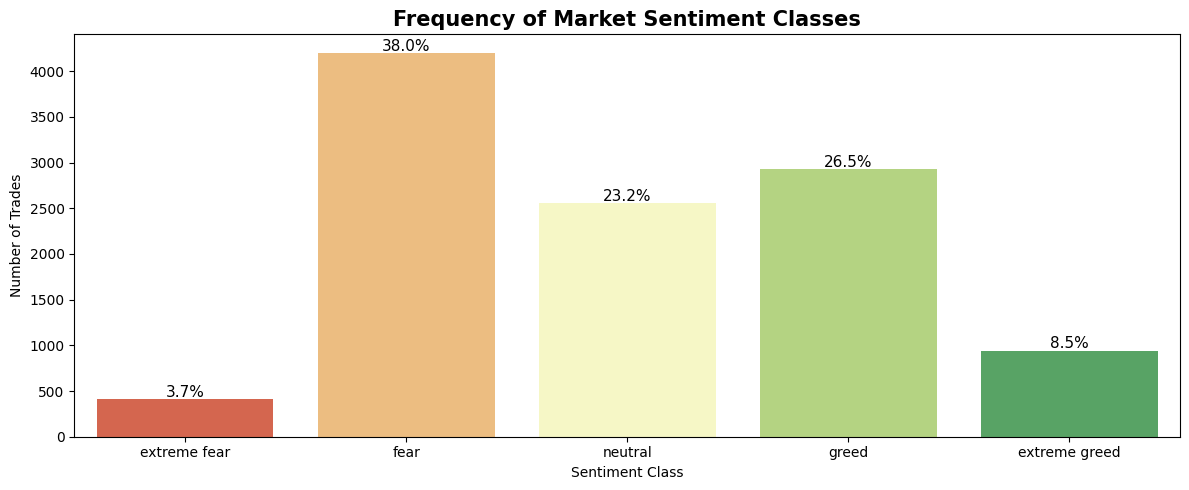

In [40]:
#DOES SENTIMENT AFFECT PROFITABILITY?
# Sentiment order for consistency
sentiment_order = ['extreme fear', 'fear', 'neutral', 'greed', 'extreme greed']
df['classification'] = pd.Categorical(df['classification'], categories=sentiment_order, ordered=True)

# Market Sentiment Landscape: Frequency
plt.figure(figsize=(12, 5))
counts = df['classification'].value_counts().reindex(sentiment_order)
percentages = df['classification'].value_counts(normalize=True).reindex(sentiment_order) * 100

ax = sns.barplot(x=counts.index, y=counts.values, hue=counts.index, legend=False, palette='RdYlGn')
plt.title('Frequency of Market Sentiment Classes', fontsize=15, fontweight='bold')
plt.ylabel('Number of Trades')
plt.xlabel('Sentiment Class')
# Add percentage labels
for i, p in enumerate(ax.patches):
    ax.annotate(f'{percentages.iloc[i]:.1f}%', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=11, color='black', xytext=(0, 5),
                textcoords='offset points')
plt.tight_layout()

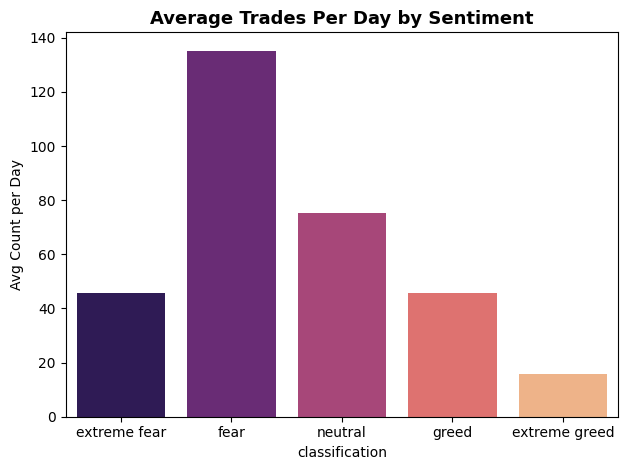

In [41]:
# Trade Activity: Avg Trades per Day
trades_per_day = df.groupby(['trade_date', 'classification'], observed=True).size().reset_index(name='trade_count')
avg_trades_per_day = trades_per_day.groupby('classification', observed=True)['trade_count'].mean().reindex(sentiment_order)


sns.barplot(x=avg_trades_per_day.index, y=avg_trades_per_day.values, hue= avg_trades_per_day.index,legend=False, palette='magma')
plt.title('Average Trades Per Day by Sentiment', fontsize=13, fontweight='bold')
plt.ylabel('Avg Count per Day')

plt.tight_layout()

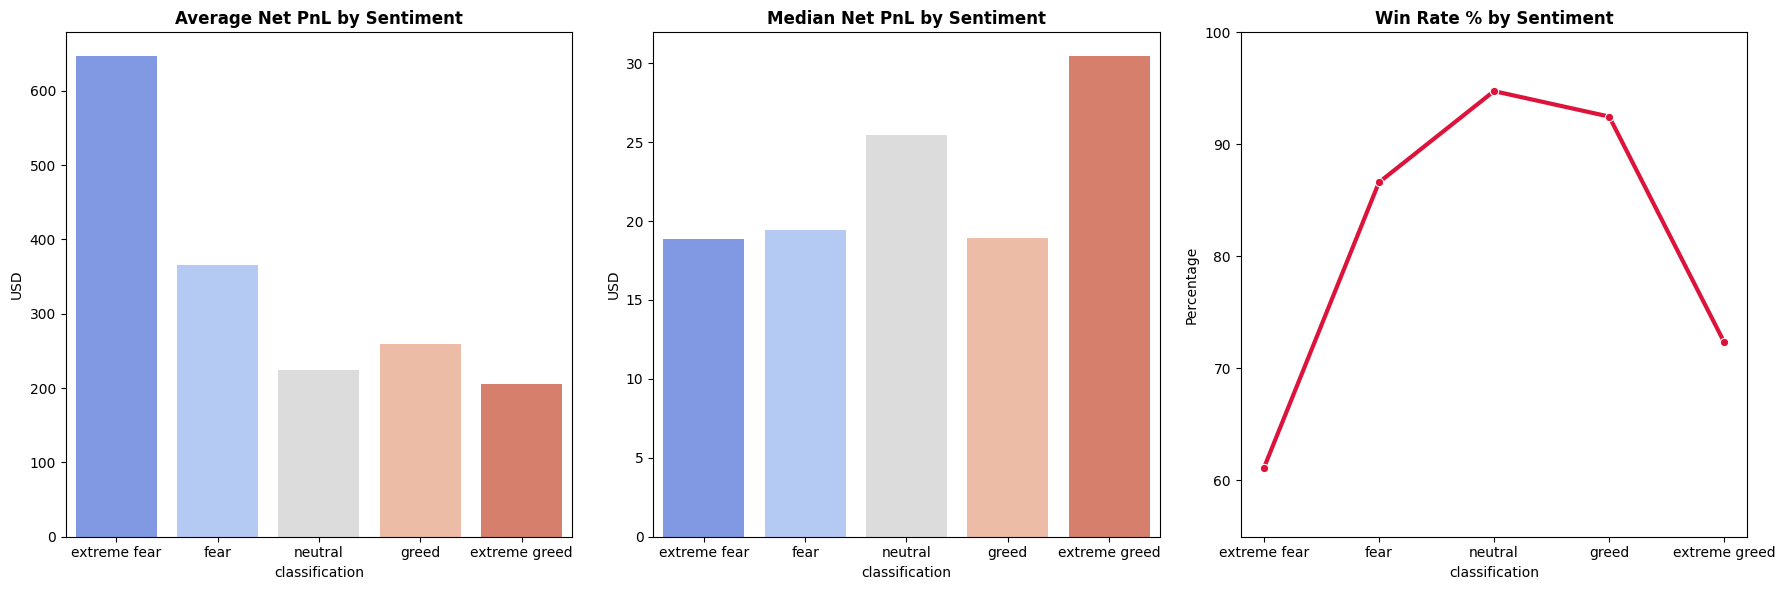

In [42]:
# Performance Analysis: PnL & Win Rate
perf_mean = df.groupby('classification', observed=True)['net_pnl'].mean().reindex(sentiment_order)
perf_median = df.groupby('classification', observed=True)['net_pnl'].median().reindex(sentiment_order)
win_rate = df.groupby('classification', observed=True)['is_win'].mean().reindex(sentiment_order) * 100

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

sns.barplot(x=perf_mean.index, y=perf_mean.values, hue=perf_mean.index, legend=False, palette='coolwarm', ax=axes[0])
axes[0].set_title('Average Net PnL by Sentiment', fontsize=12, fontweight='bold')
axes[0].set_ylabel('USD')

sns.barplot(x=perf_median.index, y=perf_median.values, hue=perf_mean.index, legend=False, palette='coolwarm', ax=axes[1])
axes[1].set_title('Median Net PnL by Sentiment', fontsize=12, fontweight='bold')
axes[1].set_ylabel('USD')

sns.lineplot(x=win_rate.index, y=win_rate.values, marker='o', color='crimson', linewidth=3, ax=axes[2])
axes[2].set_title('Win Rate % by Sentiment', fontsize=12, fontweight='bold')
axes[2].set_ylabel('Percentage')
axes[2].set_ylim(min(win_rate)*0.9, 100)

plt.tight_layout()

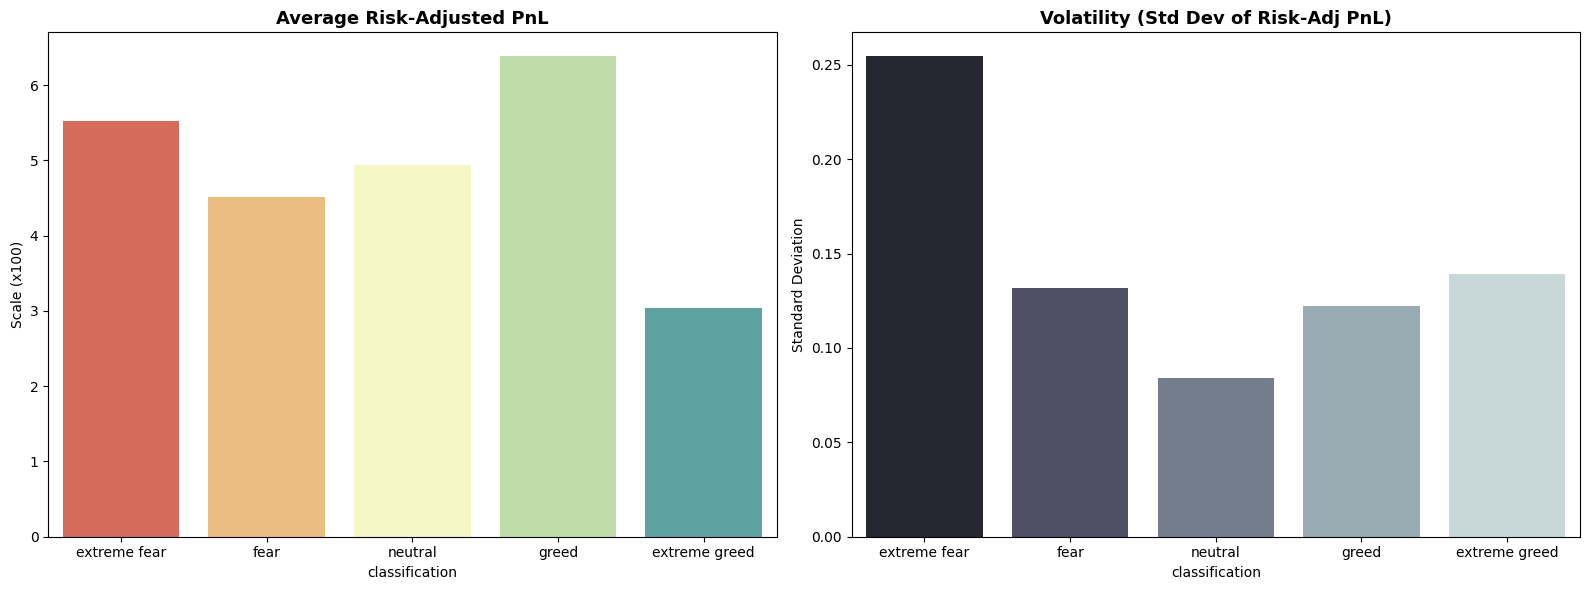

In [43]:
# Risk-Adjusted Performance (Mean & Volatility)
risk_mean = df.groupby('classification', observed=True)['risk_adjusted_pnl'].mean().reindex(sentiment_order) * 100
risk_std = df.groupby('classification', observed=True)['risk_adjusted_pnl'].std().reindex(sentiment_order)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

sns.barplot(x=risk_mean.index, y=risk_mean.values,hue=risk_std.index, legend=False,palette='Spectral', ax=ax1)
ax1.set_title('Average Risk-Adjusted PnL', fontsize=13, fontweight='bold')
ax1.set_ylabel('Scale (x100)')

# We look at the standard deviation of PnL to see when the market is "riskiest"
sns.barplot(x=risk_std.index, y=risk_std.values,hue=risk_std.index, legend=False, palette='bone', ax=ax2)
ax2.set_title('Volatility (Std Dev of Risk-Adj PnL)', fontsize=13, fontweight='bold')
ax2.set_ylabel('Standard Deviation')

plt.tight_layout()

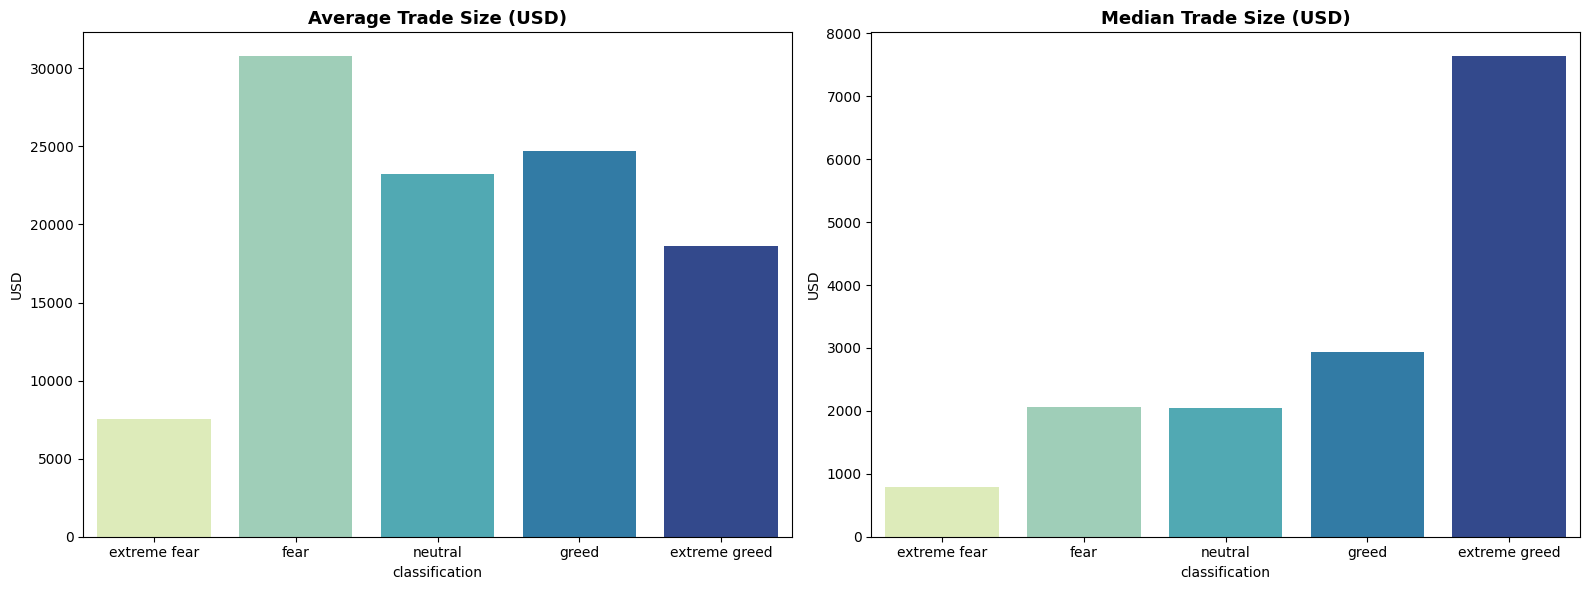

In [44]:
# Trade Size Behavior
size_mean = df.groupby('classification', observed=True)['Size USD'].mean().reindex(sentiment_order)
size_median = df.groupby('classification', observed=True)['Size USD'].median().reindex(sentiment_order)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

sns.barplot(x=size_mean.index, y=size_mean.values,hue=size_mean.index,legend=False, palette='YlGnBu', ax=ax1)
ax1.set_title('Average Trade Size (USD)', fontsize=13, fontweight='bold')
ax1.set_ylabel('USD')

sns.barplot(x=size_median.index, y=size_median.values,hue=size_median.index,legend=False, palette='YlGnBu', ax=ax2)
ax2.set_title('Median Trade Size (USD)', fontsize=13, fontweight='bold')
ax2.set_ylabel('USD')

plt.tight_layout()

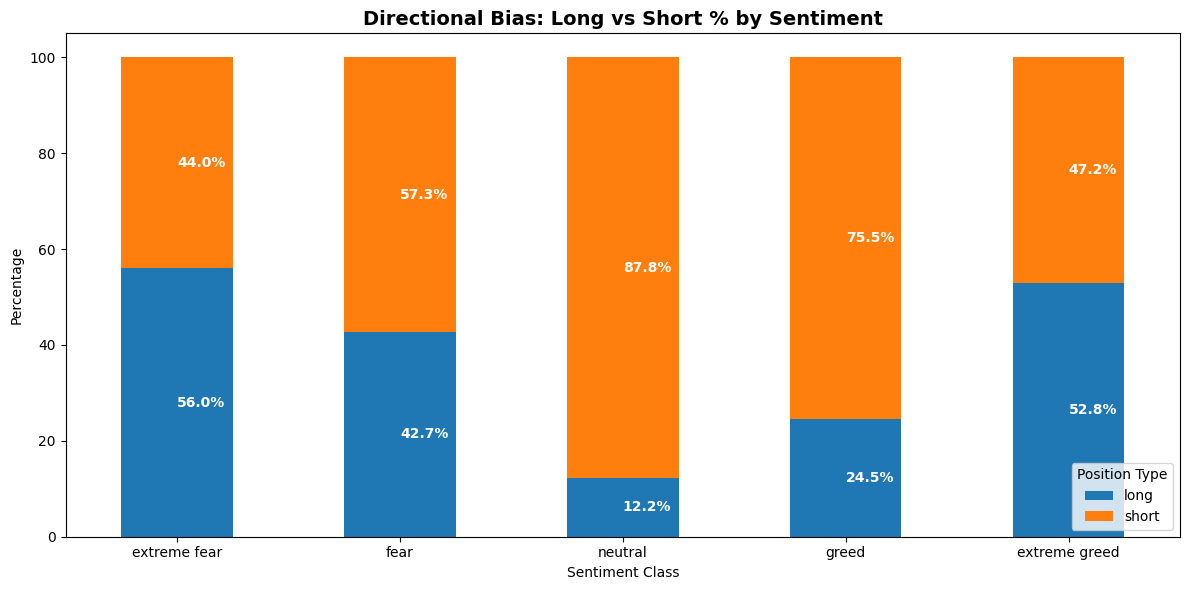

In [45]:
# Directional Bias: Long vs Short distribution
pivot_direction = pd.crosstab(df['classification'], df['position_type'], normalize='index') * 100
pivot_direction = pivot_direction.reindex(sentiment_order)

ax = pivot_direction.plot(kind='bar', stacked=True, figsize=(12, 6), color=['#1f77b4', '#ff7f0e'])
plt.title('Directional Bias: Long vs Short % by Sentiment', fontsize=14, fontweight='bold')
plt.ylabel('Percentage')
plt.xlabel('Sentiment Class')
plt.legend(title='Position Type', loc='lower right')
plt.xticks(rotation=0)

# Add value labels
for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    if height > 0:
        ax.text(x+width/2, y+height/2, f'{height:.1f}%', va='center', color='white', fontweight='bold')

plt.tight_layout()

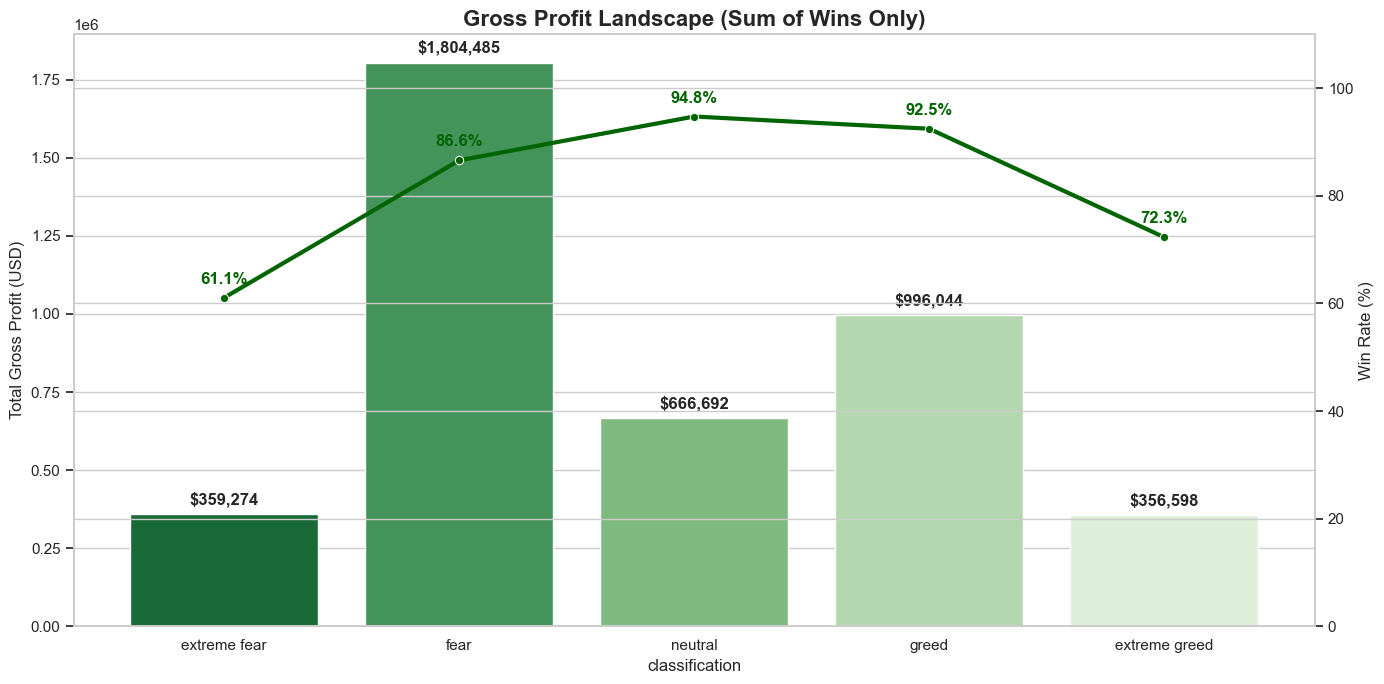

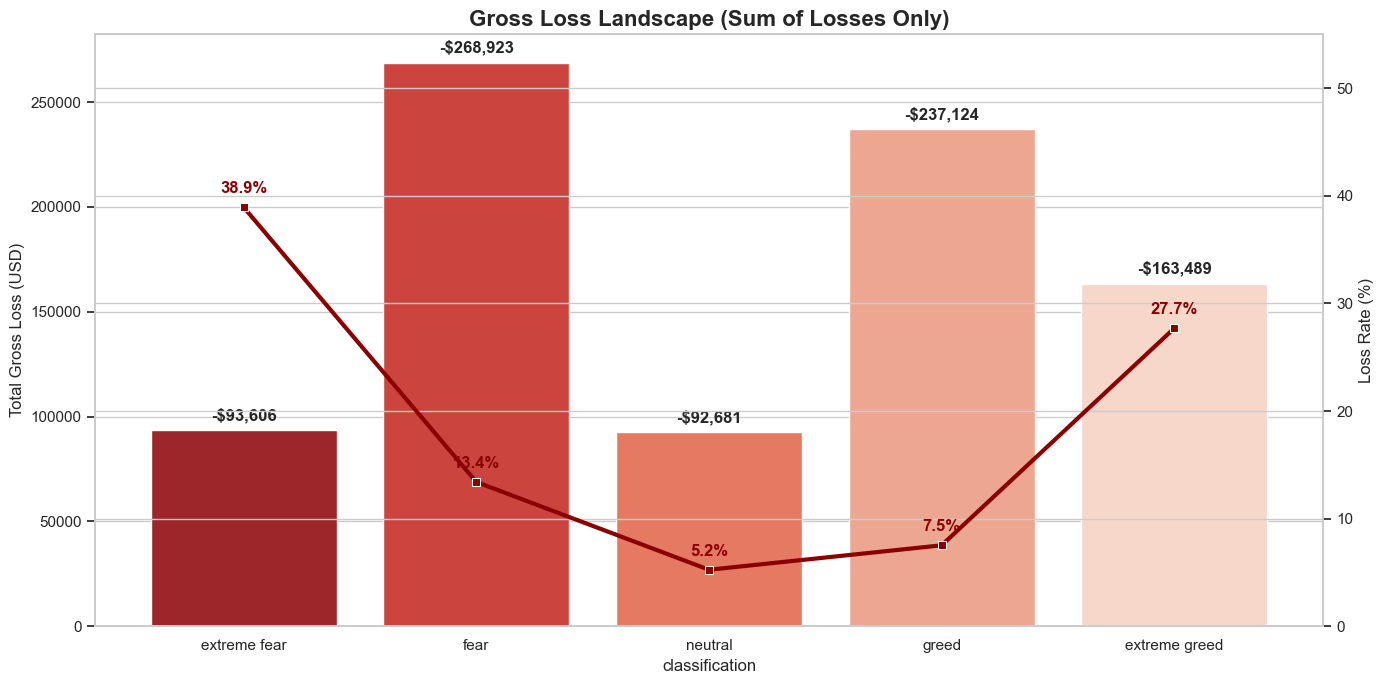

In [46]:
# Calculation - GROSS PROFIT
gross_profit_list = []
for sentiment in sentiment_order:
    subset = df[df['classification'] == sentiment]
    winning_trades = subset[subset['is_win'] == True]
    
    gross_profit = winning_trades['net_pnl'].sum()
    win_rate = (subset['is_win'] == True).mean() * 100 if len(subset) > 0 else 0
    
    gross_profit_list.append({
        'classification': sentiment,
        'gross_profit': gross_profit,
        'win_rate': win_rate
    })

gross_profit_df = pd.DataFrame(gross_profit_list)

# Calculation - GROSS LOSS (Only losing trades)
gross_loss_list = []
for sentiment in sentiment_order:
    subset = df[df['classification'] == sentiment]
    losing_trades = subset[subset['is_win'] == False]
    
    gross_loss = losing_trades['net_pnl'].sum() # This will be negative
    loss_rate = (subset['is_win'] == False).mean() * 100 if len(subset) > 0 else 0
    
    gross_loss_list.append({
        'classification': sentiment,
        'gross_loss': gross_loss,
        'loss_rate': loss_rate
    })

gross_loss_df = pd.DataFrame(gross_loss_list)
gross_loss_df['abs_loss'] = gross_loss_df['gross_loss'].abs()

# PLOTTING
sns.set_theme(style="whitegrid")

# Gross Profit Landscape
fig1, ax1 = plt.subplots(figsize=(14, 7))
sns.barplot(data=gross_profit_df, x='classification', y='gross_profit', hue='classification', palette='Greens_r', ax=ax1)
ax1.set_title('Gross Profit Landscape (Sum of Wins Only)', fontsize=16, fontweight='bold')
ax1.set_ylabel('Total Gross Profit (USD)')

for i, p in enumerate(ax1.patches):
    ax1.annotate(f'${p.get_height():,.0f}', (p.get_x() + p.get_width() / 2., p.get_height()), 
                 ha='center', va='bottom', xytext=(0, 5), textcoords='offset points', fontweight='bold')

ax2 = ax1.twinx()
sns.lineplot(x=np.arange(len(gross_profit_df)), y=gross_profit_df['win_rate'], marker='o', color='darkgreen', linewidth=3, ax=ax2)
ax2.set_ylabel('Win Rate (%)')
ax2.set_ylim(0, 110)
# Add Win Rate labels on the line points
for i, val in enumerate(gross_profit_df['win_rate']):
    ax2.annotate(f'{val:.1f}%', (i, val), xytext=(0, 10), textcoords="offset points", ha='center', fontweight='bold', color='darkgreen')
plt.tight_layout()

# Gross Loss Landscape
fig2, ax3 = plt.subplots(figsize=(14, 7))
sns.barplot(data=gross_loss_df, x='classification', y='abs_loss', hue='classification', palette='Reds_r', ax=ax3)
ax3.set_title('Gross Loss Landscape (Sum of Losses Only)', fontsize=16, fontweight='bold')
ax3.set_ylabel('Total Gross Loss (USD)')

for i, p in enumerate(ax3.patches):
    ax3.annotate(f'-${p.get_height():,.0f}', (p.get_x() + p.get_width() / 2., p.get_height()), 
                 ha='center', va='bottom', xytext=(0, 5), textcoords='offset points', fontweight='bold')

ax4 = ax3.twinx()
sns.lineplot(x=np.arange(len(gross_loss_df)), y=gross_loss_df['loss_rate'], marker='s', color='darkred', linewidth=3, ax=ax4)
ax4.set_ylabel('Loss Rate (%)')
ax4.set_ylim(0, 55)
for i, val in enumerate(gross_loss_df['loss_rate']):
    ax4.annotate(f'{val:.1f}%', (i, val), xytext=(0, 10), textcoords="offset points", ha='center', fontweight='bold', color='darkred')
plt.tight_layout()

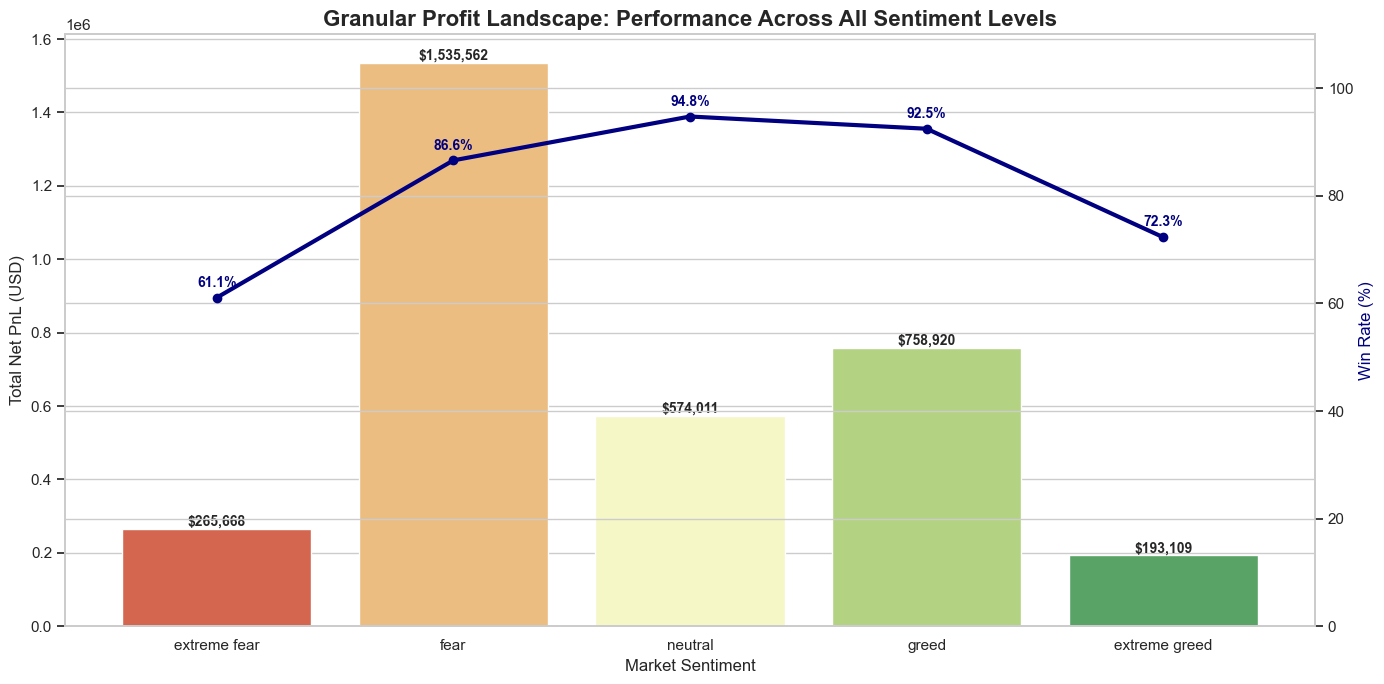

In [47]:
df['classification'] = pd.Categorical(df['classification'], categories=sentiment_order, ordered=True)

# Detailed Sentiment Profit/Loss Analysis (All 5 categories)
sentiment_metrics = df.groupby('classification', observed=True).agg(
    total_net_pnl=('net_pnl', 'sum'),
    win_rate=('is_win', 'mean'),
    trade_count=('Account', 'count')
).reset_index()

sentiment_metrics['win_rate_pct'] = sentiment_metrics['win_rate'] * 100

# Visualizations
plt.figure(figsize=(14, 7))

# Bar Plot
sns.barplot(data=sentiment_metrics, x='classification', y='total_net_pnl', hue='classification',legend=False, palette='RdYlGn')
plt.title('Granular Profit Landscape: Performance Across All Sentiment Levels', fontsize=16, fontweight='bold')
plt.ylabel('Total Net PnL (USD)', fontsize=12)
plt.xlabel('Market Sentiment', fontsize=12)

# Add PnL Labels using plt.text
for i, val in enumerate(sentiment_metrics['total_net_pnl']):
    plt.text(i, val, f'${val:,.0f}', ha='center', va='bottom', fontweight='bold', fontsize=10)

# Create twin axis functionally
plt.twinx()

# Line Plot on the twin axis
plt.plot(sentiment_metrics['classification'], sentiment_metrics['win_rate_pct'], 
         marker='o', color='navy', linewidth=3, label='Win Rate %')
plt.ylabel('Win Rate (%)', color='navy', fontsize=12)
plt.ylim(0, 110)

# Add Win Rate Labels
for i, val in enumerate(sentiment_metrics['win_rate_pct']):
    plt.text(i, val + 2, f'{val:.1f}%', ha='center', fontweight='bold', color='navy', fontsize=10)

plt.tight_layout()

  classification  Crossed        Fee   Execution Type
0   extreme fear    False   0.956155     Maker (Wait)
1   extreme fear     True   1.129159  Taker (Crossed)
2           fear    False   0.705731     Maker (Wait)
3           fear     True  10.130798  Taker (Crossed)
4        neutral    False   0.258272     Maker (Wait)
5        neutral     True   5.464015  Taker (Crossed)
6          greed    False   0.314027     Maker (Wait)
7          greed     True   7.530281  Taker (Crossed)
8  extreme greed    False   1.160175     Maker (Wait)
9  extreme greed     True   6.591294  Taker (Crossed)


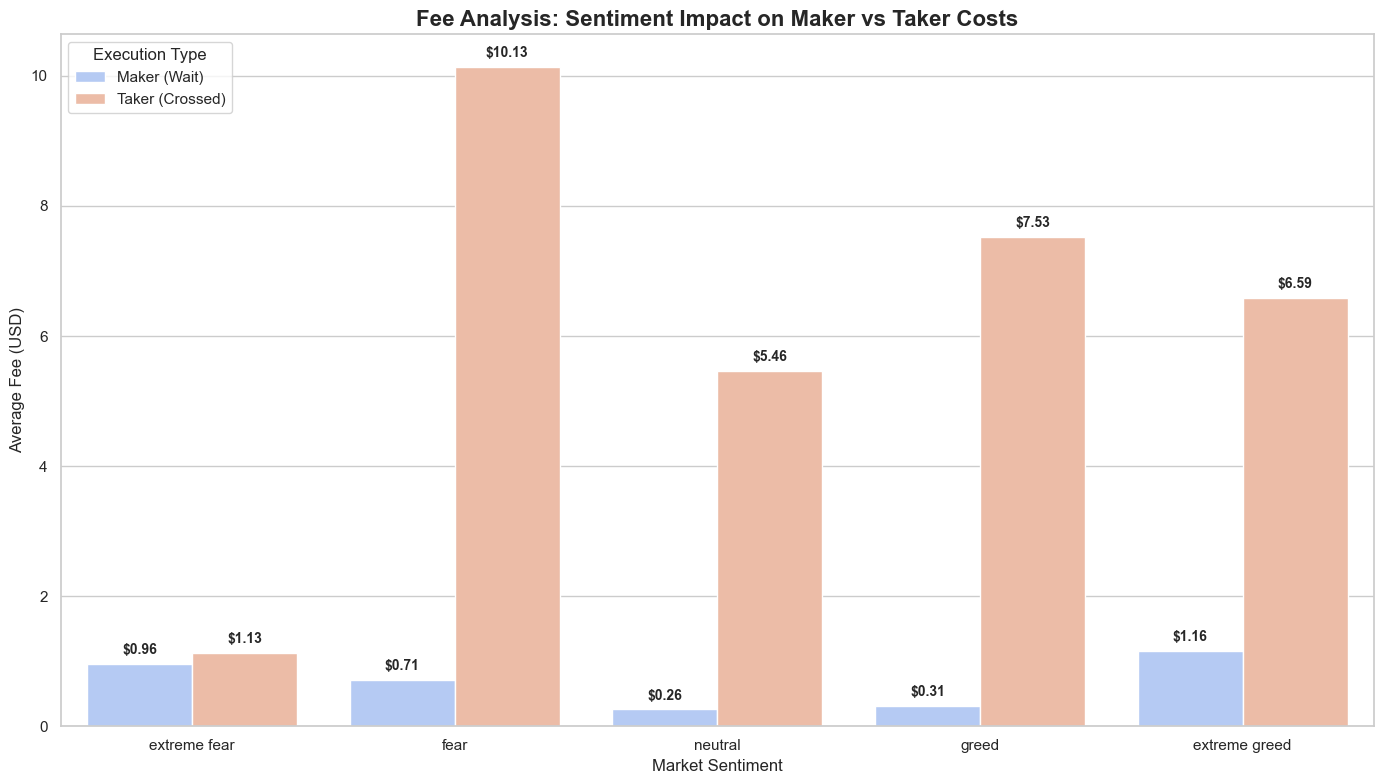

In [48]:
# Calculation - Average Fee by Sentiment and Crossed (Maker vs Taker)
fee_stats = df.groupby(['classification', 'Crossed'], observed=True)['Fee'].mean().reset_index()

# Rename Crossed for better legend
fee_stats['Execution Type'] = fee_stats['Crossed'].map({True: 'Taker (Crossed)', False: 'Maker (Wait)'})

# VISUALIZATION: Fee vs Sentiment vs Crossed
plt.figure(figsize=(14, 8))
sns.set_theme(style="whitegrid")

# Using the functional plt interface as requested
sns.barplot(data=fee_stats, x='classification', y='Fee', hue='Execution Type', palette='coolwarm')

plt.title('Fee Analysis: Sentiment Impact on Maker vs Taker Costs', fontsize=16, fontweight='bold')
plt.ylabel('Average Fee (USD)', fontsize=12)
plt.xlabel('Market Sentiment', fontsize=12)
plt.legend(title='Execution Type', loc='upper left')

# Annotating values on the bars
for p in plt.gca().patches:
    if p.get_height() > 0: # Avoid annotating empty bars
        plt.annotate(f'${p.get_height():.2f}', 
                     (p.get_x() + p.get_width() / 2., p.get_height()), 
                     ha='center', va='bottom', xytext=(0, 5), 
                     textcoords='offset points', fontweight='bold', fontsize=10)

plt.tight_layout()
#plt.savefig('fee_sentiment_crossed_landscape.png')

# summary
print(fee_stats)

Performance Metrics Table:
       Sentiment     Avg_PnL   Volatility  Max_Single_Profit  Trade_Count  \
0   extreme fear  647.413852  6420.670505       115287.00000          411   
1           fear  371.414938  3214.465586       135329.09010         4193   
2        neutral  229.490315  1136.639606        33085.48440         2553   
3          greed  264.643958  3213.470428        71535.71674         2925   
4  extreme greed  211.019260  2047.636759        29999.90625          939   

   Win_Rate      Avg_Size  
0  0.610706   7513.270706  
1  0.865967  30770.952788  
2  0.947513  23219.901790  
3  0.924786  24705.406366  
4  0.723110  18623.253333  


Text(0.5, 1.0, 'Asset-Specific Alpha: Avg PnL by Coin & Sentiment')

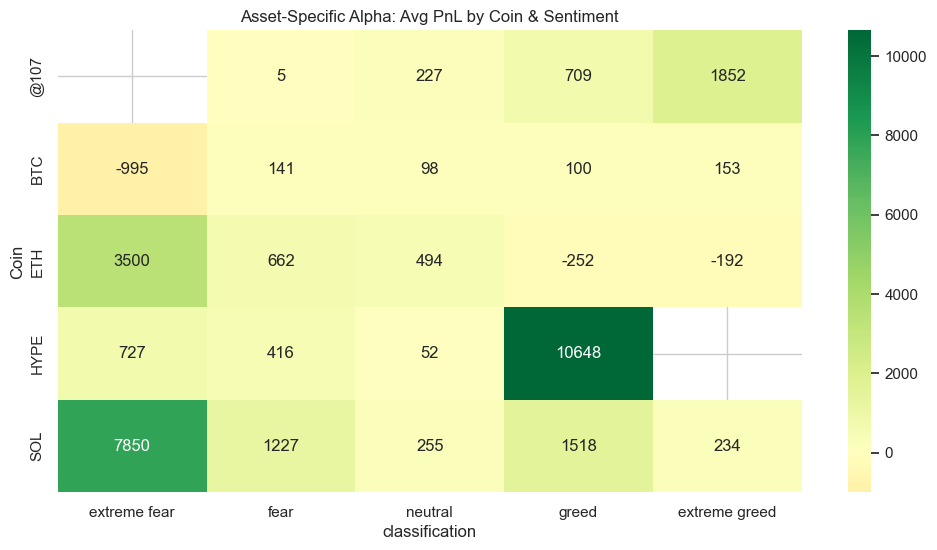

In [49]:
# THE PERFORMANCE HIERARCHY 
performance = df.groupby('classification', observed=False).agg({
    'Closed PnL': ['mean', 'std', 'max', 'count'],
    'is_win': 'mean',
    'Size USD': 'mean'
}).reset_index()
performance.columns = ['Sentiment', 'Avg_PnL', 'Volatility', 'Max_Single_Profit', 'Trade_Count', 'Win_Rate', 'Avg_Size']
print("Performance Metrics Table:")
print(performance)

# ASSET ALPHA HEATMAP
top_5_coins = df['Coin'].value_counts().head(5).index
asset_map = df[df['Coin'].isin(top_5_coins)].groupby(['Coin', 'classification'], observed=False)['Closed PnL'].mean().unstack()
plt.figure(figsize=(12, 6))
sns.heatmap(asset_map, annot=True, cmap='RdYlGn', fmt=".0f", center=0)
plt.title('Asset-Specific Alpha: Avg PnL by Coin & Sentiment')

Text(0.5, 1.0, 'Win Rate Heatmap: Asset vs Sentiment')

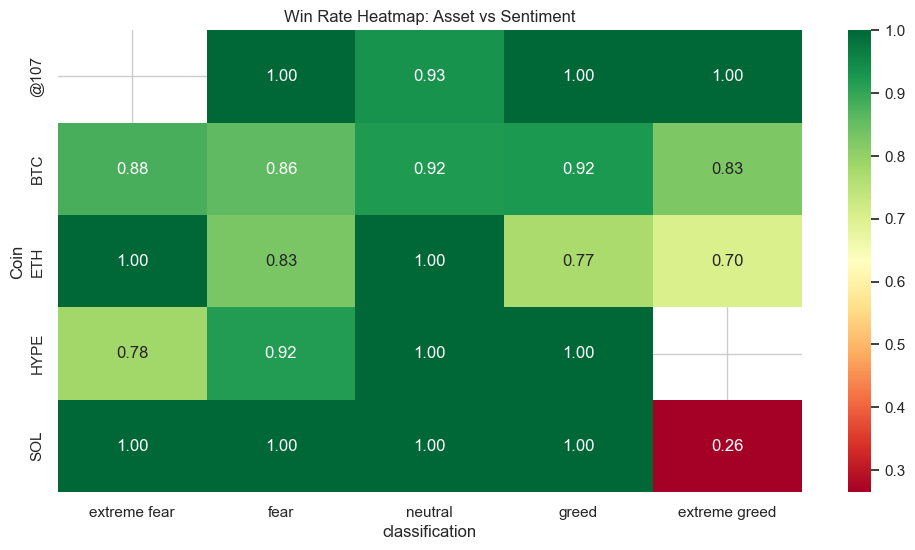

In [50]:
# Success Rate (Win Rate) Heatmap: Asset vs Sentiment
top_5_coins = df['Coin'].value_counts().head(5).index
df['is_win'] = df['Closed PnL'] > 0
win_rate_matrix = df[df['Coin'].isin(top_5_coins)].groupby(['Coin', 'classification'],observed=False)['is_win'].mean().unstack()

plt.figure(figsize=(12, 6))
sns.heatmap(win_rate_matrix, annot=True, cmap='RdYlGn', fmt=".2f")
plt.title('Win Rate Heatmap: Asset vs Sentiment')

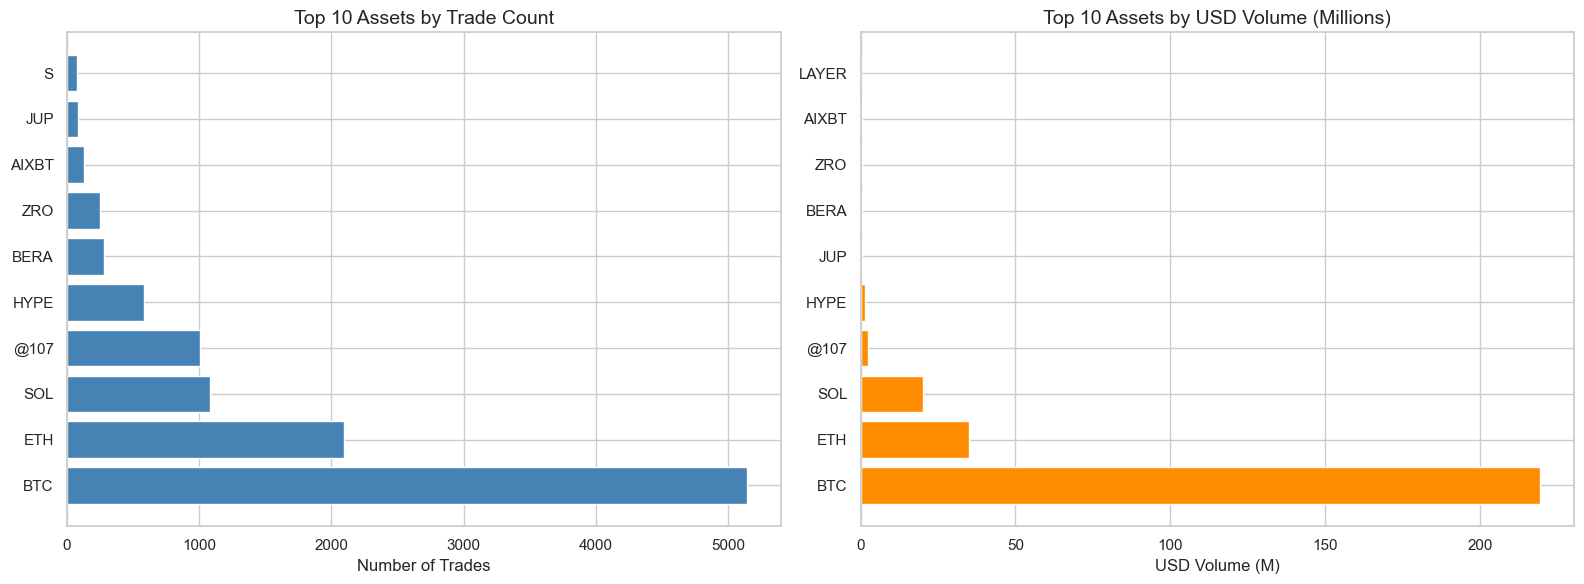

In [51]:
# Top assets by trade count
top_assets_count = df['Coin'].value_counts().head(10)
# Top assets by USD volume
top_assets_vol = df.groupby('Coin')['Size USD'].sum().sort_values(ascending=False).head(10)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Trade Count
axes[0].barh(top_assets_count.index, top_assets_count.values, color='steelblue')
axes[0].set_title('Top 10 Assets by Trade Count', fontsize=14)
axes[0].set_xlabel('Number of Trades')

# USD Volume
axes[1].barh(top_assets_vol.index, top_assets_vol.values / 1e6, color='darkorange')
axes[1].set_title('Top 10 Assets by USD Volume (Millions)', fontsize=14)
axes[1].set_xlabel('USD Volume (M)')

plt.tight_layout()
plt.show()

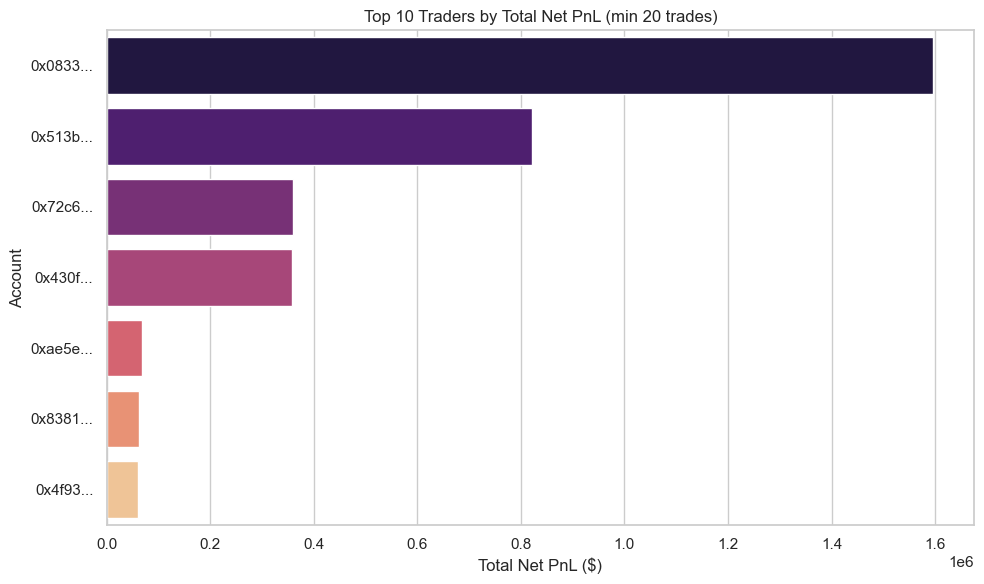

In [52]:
# Aggregate by Account
trader_perf = (
    df.groupby('Account')
    .agg(
        total_pnl=('net_pnl', 'sum'),
        avg_risk_adj_pnl=('risk_adjusted_pnl', 'mean'),
        trade_count=('net_pnl', 'size'),
        win_rate=('is_win', 'mean')
    )
    .query('trade_count >= 20')  # filter active traders
    .sort_values('total_pnl', ascending=False)
    .head(10)
)
trader_perf.index = [addr[:6] + '...' for addr in trader_perf.index]
# Plot total PnL
plt.figure(figsize=(10, 6))
sns.barplot(x=trader_perf['total_pnl'], y=trader_perf.index, hue=trader_perf.index, legend = False, palette='magma')
plt.title('Top 10 Traders by Total Net PnL (min 20 trades)')
plt.xlabel('Total Net PnL ($)')
plt.ylabel('Account')
plt.tight_layout()
plt.show()

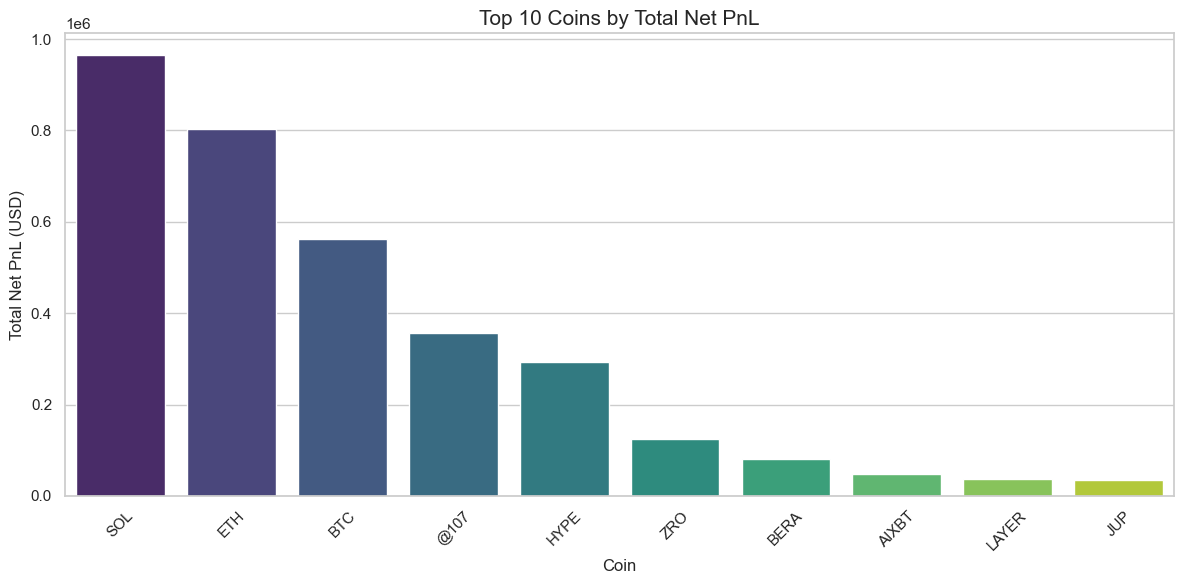

In [53]:
# Define coin_stats (Net PnL per Coin)
coin_stats = df.groupby('Coin')['net_pnl'].sum().sort_values(ascending=False).reset_index()
#Top 10 Coins by Net PnL
plt.figure(figsize=(12, 6))
top_coins = coin_stats.head(10)
sns.barplot(data=top_coins, x='Coin', y='net_pnl', hue='Coin' , legend = False, palette='viridis')
plt.title('Top 10 Coins by Total Net PnL', fontsize=15)
plt.xlabel('Coin')
plt.ylabel('Total Net PnL (USD)')
plt.xticks(rotation=45)
plt.tight_layout()

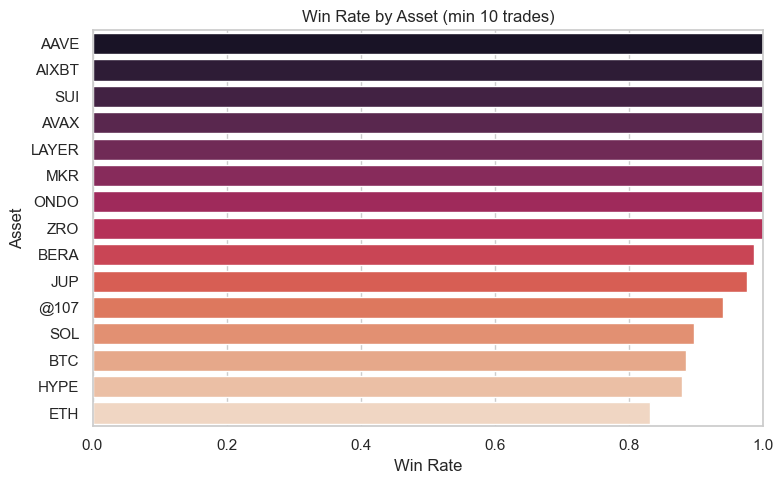

In [54]:
# Compute win rate per asset (only for assets with >=10 trades)
win_rate_by_asset = (
    df.groupby('Coin')['is_win']
    .agg(['mean', 'size'])
    .rename(columns={'mean': 'win_rate', 'size': 'trade_count'})
    .query('trade_count >= 10')
    .sort_values('win_rate', ascending=False)
    .head(15)  # top 15 by win rate
)

plt.figure(figsize=(8, 5))
sns.barplot(x=win_rate_by_asset['win_rate'], y=win_rate_by_asset.index, hue =win_rate_by_asset.index ,legend=False, palette='rocket')
plt.title('Win Rate by Asset (min 10 trades)')
plt.xlabel('Win Rate')
plt.ylabel('Asset')
plt.xlim(0, 1)
plt.tight_layout()
plt.show()

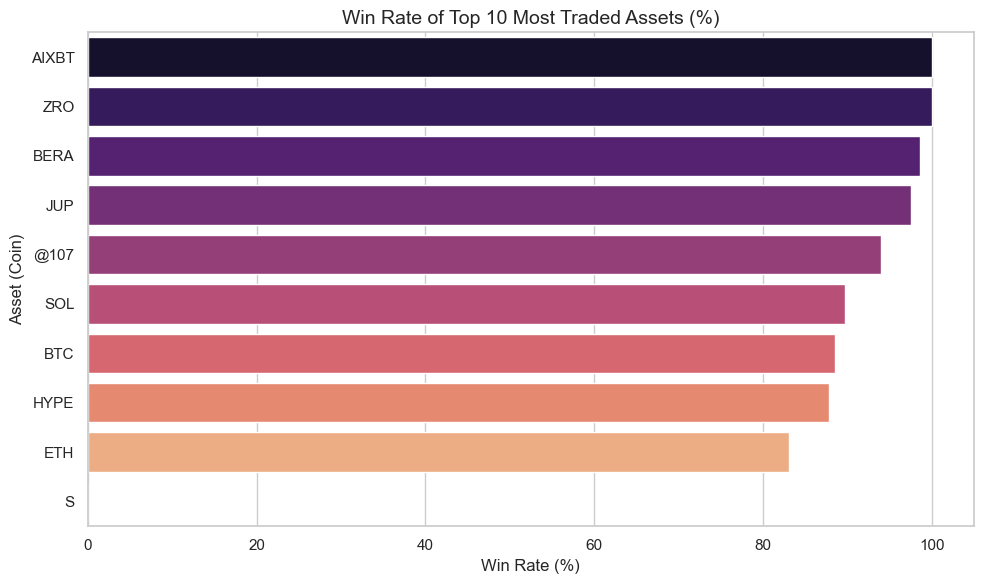

In [55]:
top_traded = df['Coin'].value_counts().head(10)
# Win Rate by Asset (for top 10 most traded)
top_coins = top_traded.index
win_rate_asset = df[df['Coin'].isin(top_coins)].groupby('Coin')['is_win'].mean().sort_values(ascending=False) * 100
plt.figure(figsize=(10, 6))
sns.barplot(x=win_rate_asset.values, y=win_rate_asset.index,hue= win_rate_asset.index,legend=False,palette='magma')
plt.title('Win Rate of Top 10 Most Traded Assets (%)', fontsize=14)
plt.xlabel('Win Rate (%)')
plt.ylabel('Asset (Coin)')
plt.tight_layout()

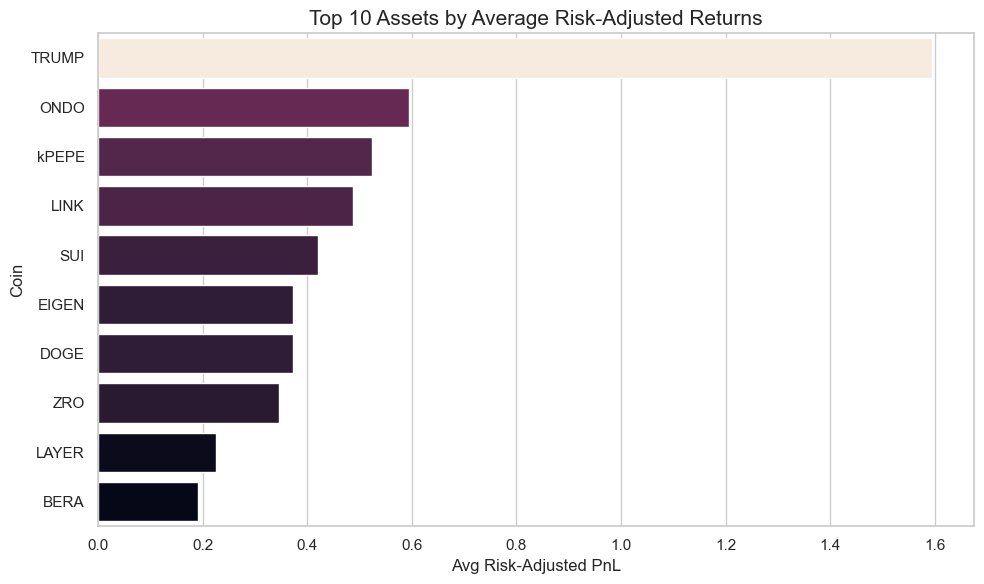

In [56]:
# Top Assets by Risk-Adjusted Returns
top_assets_risk = df.groupby('Coin')['risk_adjusted_pnl'].mean().sort_values(ascending=False).head(10)
plt.figure(figsize=(10, 6))
sns.barplot(x=top_assets_risk.values, y=top_assets_risk.index, hue=top_assets_risk.values, legend=False, palette='rocket')
plt.title('Top 10 Assets by Average Risk-Adjusted Returns', fontsize=15)
plt.xlabel('Avg Risk-Adjusted PnL')
plt.tight_layout()

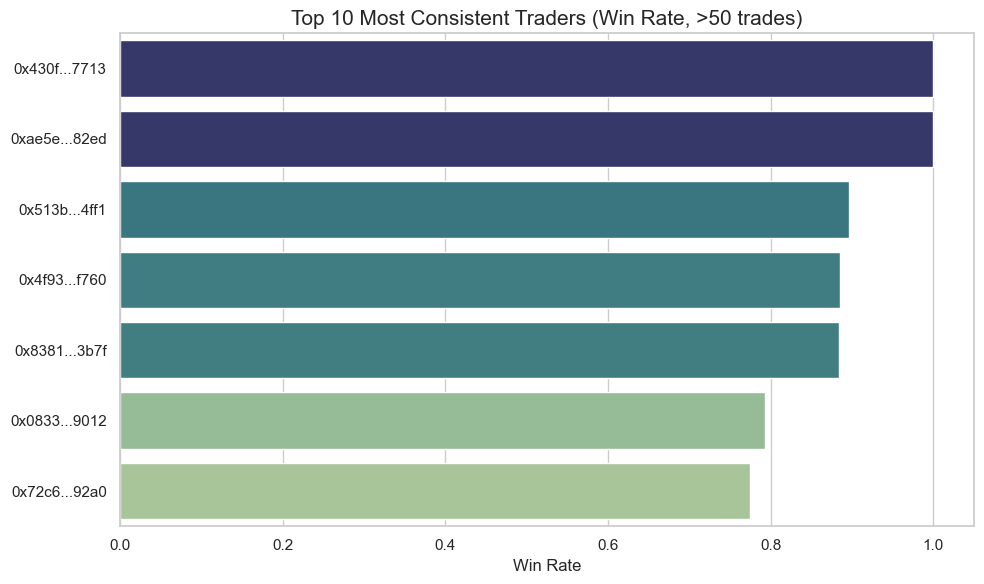

In [57]:
# Top Consistent Traders (by Win Rate - accounts with > 50 trades)
trader_counts = df['Account'].value_counts()
active_traders = trader_counts[trader_counts > 50].index
top_consistent = df[df['Account'].isin(active_traders)].groupby('Account')['is_win'].mean().sort_values(ascending=False).head(10)
short_acc = [a[:6] + '...' + a[-4:] for a in top_consistent.index]

plt.figure(figsize=(10, 6))
sns.barplot(x=top_consistent.values, y=short_acc, hue=top_consistent.values,legend=False, palette='crest')
plt.title('Top 10 Most Consistent Traders (Win Rate, >50 trades)', fontsize=15)
plt.xlabel('Win Rate')
plt.tight_layout()

In [58]:
# INSIGHT: WEEKEND WARRIORS vs WEEKDAY PROS
# Comparing win rate and ROI on weekends vs weekdays across sentiment classes.
weekend_analysis = df.groupby(['is_weekend', 'classification'], observed=False)['is_win'].mean().unstack()

# OUTLIER DEEP DIVE
# Identifying the "Super-Trades" (Top 0.5% by ROI)
top_threshold = df['risk_adjusted_pnl'].quantile(0.995)
super_trades = df[df['risk_adjusted_pnl'] >= top_threshold]

outlier_summary = {
    "count": len(super_trades),
    "risk_adjusted_pnl": super_trades['risk_adjusted_pnl'].mean(),
    "top_coin": super_trades['Coin'].value_counts().idxmax(),
    "common_sentiment": super_trades['classification'].value_counts().idxmax(),
    "common_day": super_trades['day_of_week'].value_counts().idxmax()
}

print("Outlier Trade Profile (Top 0.5% risk_adjusted_pnl)")
for k, v in outlier_summary.items():
    print(f"{k}: {v}")
    
# # 4. INSIGHT: ASSET HIERARCHY IN PANIC
# # How do Top 8 coins vs. Others react during 'Extreme Fear'?
panic_assets = df[df['classification'] == 'extreme fear'].groupby('Coin', observed=False)['risk_adjusted_pnl'].mean().sort_values(ascending=False)
print("\nPanic Asset Performance (Extreme Fear)")
print(panic_assets)

Outlier Trade Profile (Top 0.5% risk_adjusted_pnl)
count: 56
risk_adjusted_pnl: 0.8401917390258388
top_coin: @107
common_sentiment: fear
common_day: Friday

Panic Asset Performance (Extreme Fear)
Coin
SOL      0.786187
HYPE     0.163027
ETH      0.147380
GMX      0.113703
AVAX     0.003410
BTC     -0.000778
XRP     -0.050570
S       -0.178216
USUAL   -0.394216
Name: risk_adjusted_pnl, dtype: float64


In [59]:
# Extract Year and Month
df['year'] = df['trade_date'].dt.year
df['month_num'] = df['trade_date'].dt.month
df['month_name'] = df['trade_date'].dt.month_name()

# Define order for days of week
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
month_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']

# Day of Week Analysis
day_analysis = df.groupby('day_of_week').agg({
    'net_pnl': 'sum',
    'is_win': 'mean',
    'risk_adjusted_pnl': 'mean'
}).reindex(day_order)

# Monthly Seasonality (Aggregated over years)
month_analysis = df.groupby('month_name').agg({
    'net_pnl': 'sum',
    'is_win': 'mean',
    'risk_adjusted_pnl': 'mean'
}).reindex(month_order).dropna() # drop months with no data

# Yearly Analysis
year_analysis = df.groupby('year').agg({
    'net_pnl': 'sum',
    'is_win': 'mean',
    'risk_adjusted_pnl': 'mean'
})

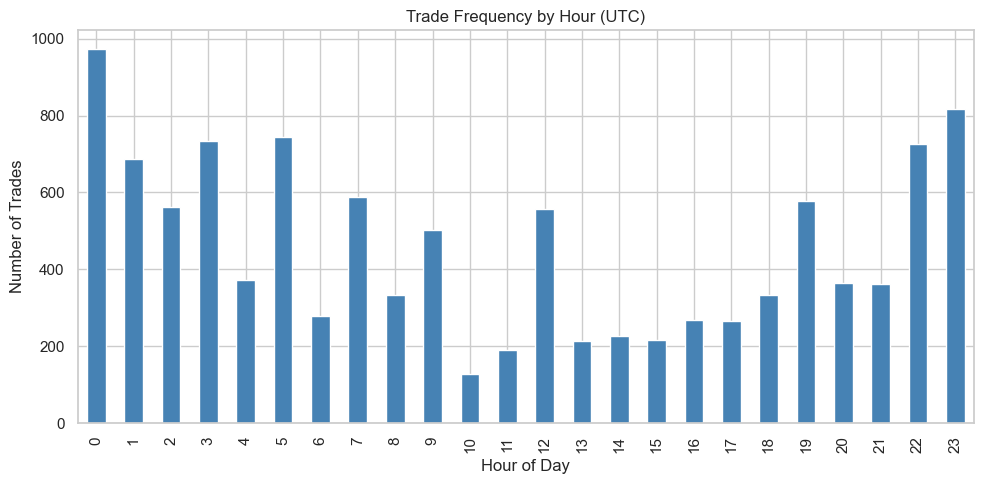

In [60]:
# Trade frequency by hour
df['hour'] = pd.to_datetime(df['trade_time'], format='%H:%M:%S').dt.hour
plt.figure(figsize=(10, 5))
df['hour'].astype(int).value_counts().sort_index().plot(kind='bar', color='steelblue')
plt.title('Trade Frequency by Hour (UTC)')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Trades')
plt.tight_layout()
plt.show()

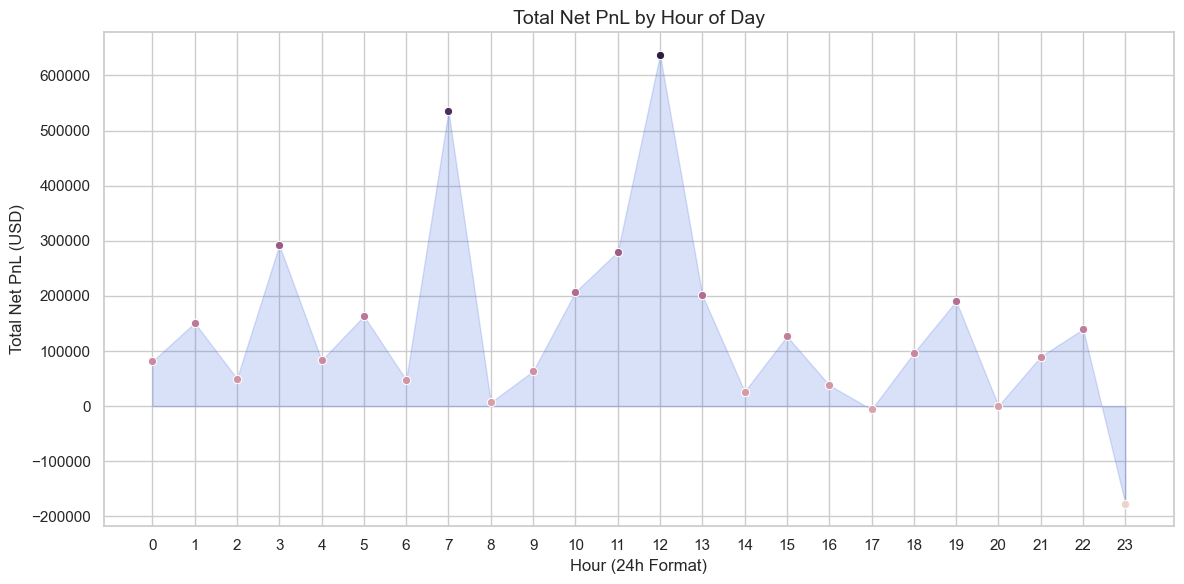

In [61]:
#Temporal Patterns (Hourly Profitability)
hourly_pnl = df.groupby('hour')['net_pnl'].sum()
plt.figure(figsize=(12, 6))
sns.lineplot(x=hourly_pnl.index, y=hourly_pnl.values,hue = hourly_pnl.values,legend=False,marker='o', color='royalblue', linewidth=2.5)
plt.fill_between(hourly_pnl.index, hourly_pnl.values, alpha=0.2, color='royalblue')
plt.title('Total Net PnL by Hour of Day', fontsize=14)
plt.xlabel('Hour (24h Format)')
plt.ylabel('Total Net PnL (USD)')
plt.xticks(range(0, 24))
plt.tight_layout()

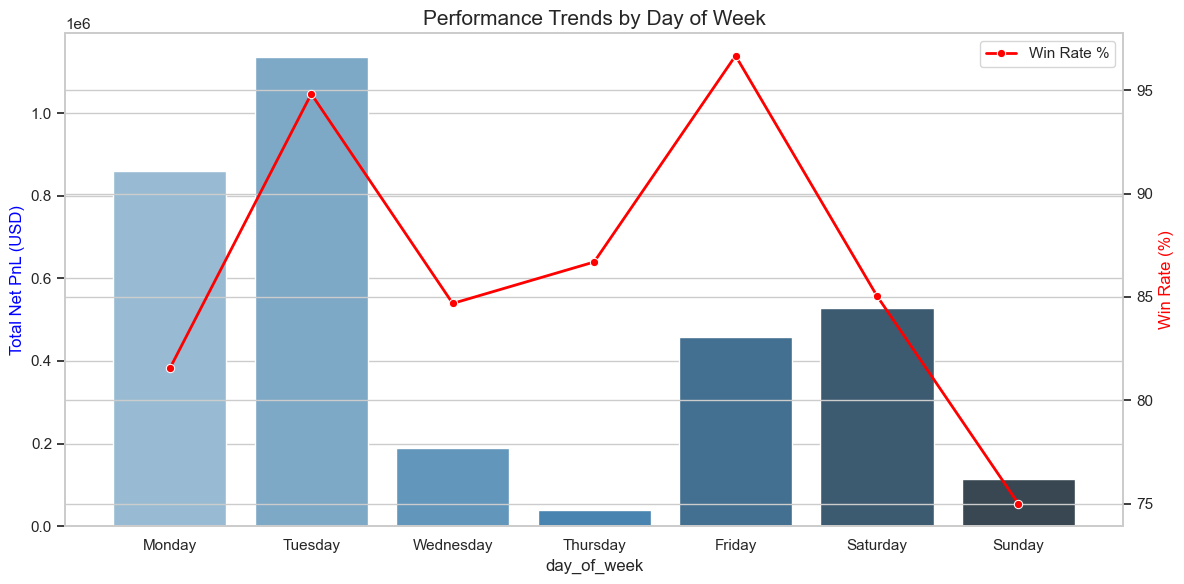

In [62]:
#Day of Week Performance (PnL and Win Rate)
fig, ax1 = plt.subplots(figsize=(12, 6))
sns.barplot(x=day_analysis.index, y=day_analysis['net_pnl'], hue = day_analysis.index,legend=False, ax=ax1, palette='Blues_d')
ax1.set_ylabel('Total Net PnL (USD)', color='blue')
ax2 = ax1.twinx()
sns.lineplot(x=day_analysis.index, y=day_analysis['is_win'] * 100, ax=ax2, color='red', marker='o', linewidth=2, label='Win Rate %')
ax2.set_ylabel('Win Rate (%)', color='red')
plt.title('Performance Trends by Day of Week', fontsize=15)
plt.tight_layout()

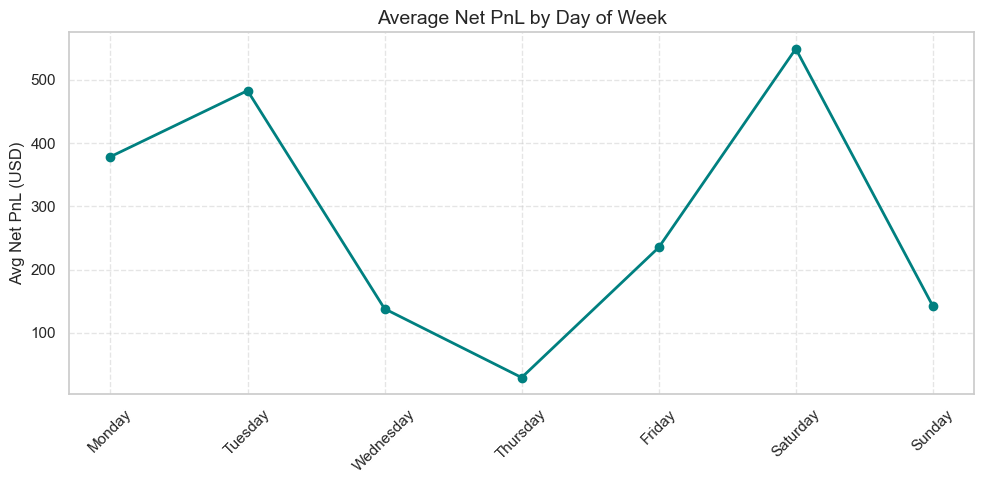

In [63]:
pnl_by_dow = df.groupby('day_of_week')['net_pnl'].mean().reindex(
    ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
)

fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(pnl_by_dow.index, pnl_by_dow.values, marker='o', linewidth=2, color='teal')
ax.set_title('Average Net PnL by Day of Week', fontsize=14)
ax.set_ylabel('Avg Net PnL (USD)')
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


--- Weekend vs Weekday Win Rates ---
classification  extreme fear      fear   neutral     greed  extreme greed
is_weekend                                                               
False               0.573333  0.895580  0.941497  0.929550       0.772849
True                1.000000  0.744526  0.985632  0.891892       0.533333


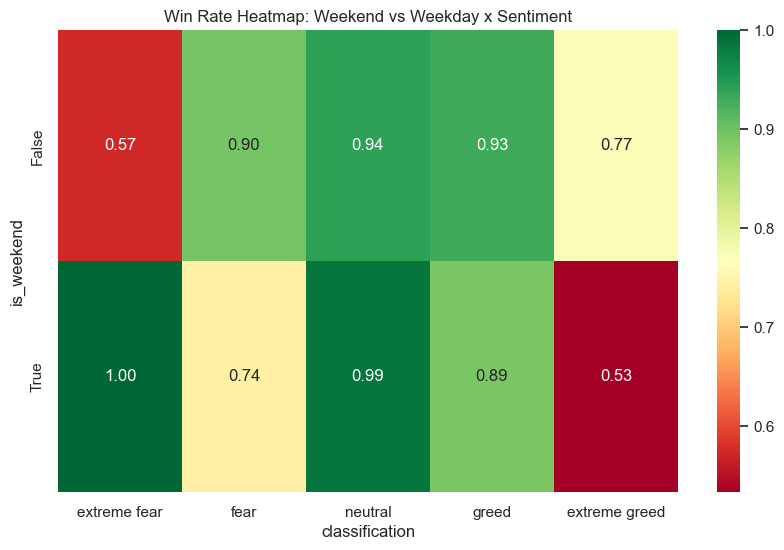

In [64]:
#WEEKEND WARRIORS vs WEEKDAY PROS
# Comparing win rate and ROI on weekends vs weekdays across sentiment classes.
weekend_analysis = df.groupby(['is_weekend', 'classification'], observed=False)['is_win'].mean().unstack()

# Visualizations
plt.figure(figsize=(10, 6))
sns.heatmap(weekend_analysis, annot=True, cmap='RdYlGn', fmt=".2f")
plt.title('Win Rate Heatmap: Weekend vs Weekday x Sentiment')
print("\n--- Weekend vs Weekday Win Rates ---")
print(weekend_analysis)

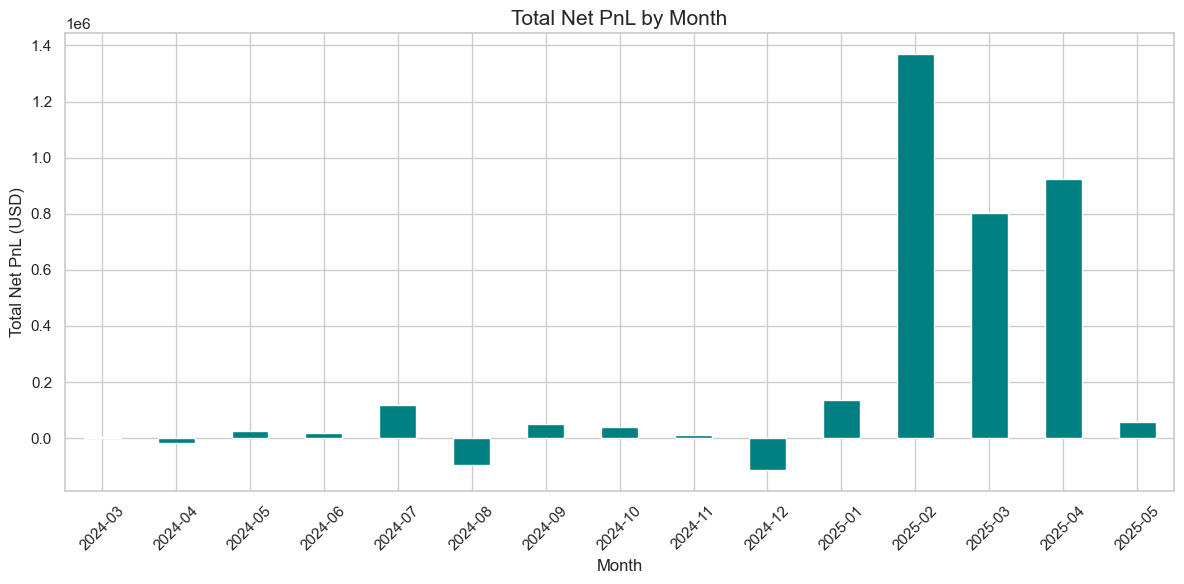

In [65]:
# Monthly Profitability
df['month'] = df['trade_date'].dt.to_period('M')
monthly_pnl = df.groupby('month')['net_pnl'].sum()
plt.figure(figsize=(12, 6))
monthly_pnl.plot(kind='bar', color='teal')
plt.title('Total Net PnL by Month', fontsize=15)
plt.xlabel('Month')
plt.ylabel('Total Net PnL (USD)')
plt.xticks(rotation=45)
plt.tight_layout()

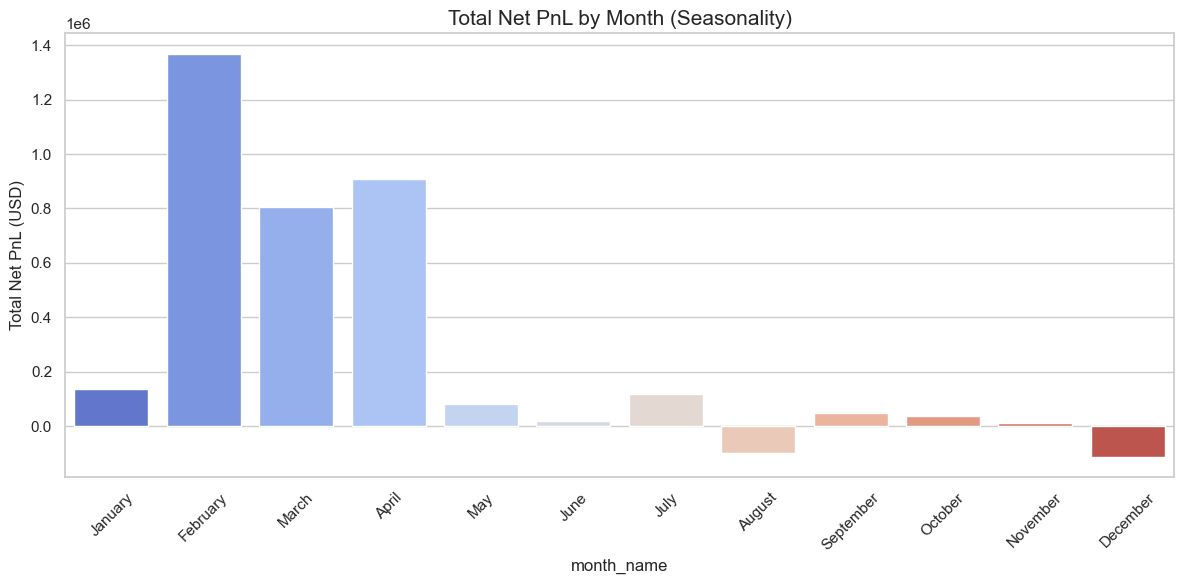

In [66]:
#Monthly Performance (Seasonality)
plt.figure(figsize=(12, 6))
sns.barplot(x=month_analysis.index, y=month_analysis['net_pnl'], hue= month_analysis.index,legend=False, palette='coolwarm')
plt.title('Total Net PnL by Month (Seasonality)', fontsize=15)
plt.ylabel('Total Net PnL (USD)')
plt.xticks(rotation=45)
plt.tight_layout()

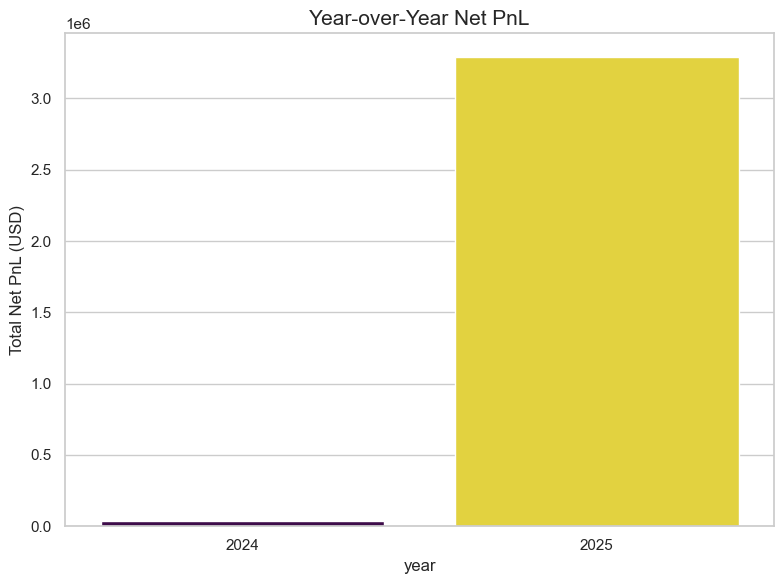

In [67]:
#Yearly Performance
plt.figure(figsize=(8, 6))
sns.barplot(x=year_analysis.index, y=year_analysis['net_pnl'], hue =year_analysis.index ,legend=False, palette='viridis')
plt.title('Year-over-Year Net PnL', fontsize=15)
plt.ylabel('Total Net PnL (USD)')
plt.tight_layout()

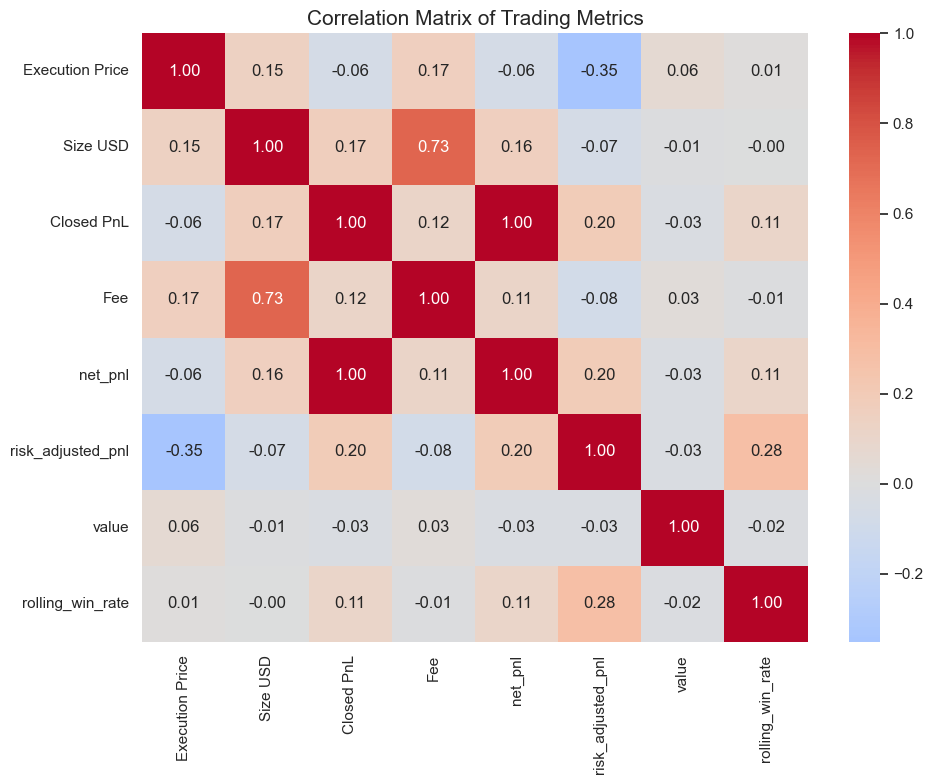

In [68]:
#Correlation Analysis
correlation_matrix = df[['Execution Price', 'Size USD', 'Closed PnL', 'Fee', 'net_pnl', 'risk_adjusted_pnl', 'value', 'rolling_win_rate']].corr()

# Correlation Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', center=0)
plt.title('Correlation Matrix of Trading Metrics', fontsize=15)
plt.tight_layout()

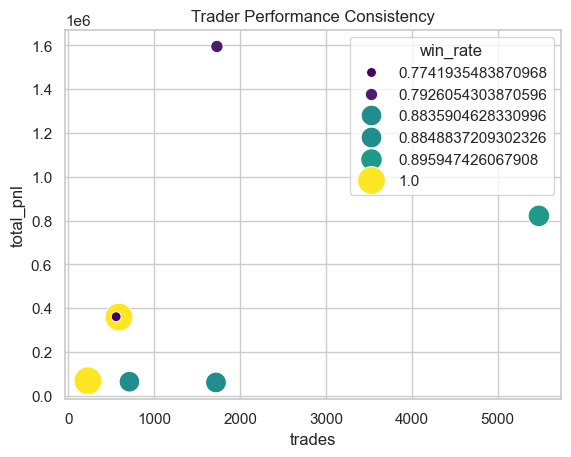

In [69]:
#TRADER CONSISTENCY (WHO SURVIVES?)
trader_perf = (
    df
    .groupby("Account")
    .agg(
        total_pnl=("net_pnl", "sum"),
        win_rate=("is_win", "mean"),
        trades=("net_pnl", "count")
    )
    .reset_index()
)

sns.scatterplot(
    data=trader_perf,
    x="trades",
    y="total_pnl",
    size="win_rate",
    hue="win_rate",
    palette="viridis",
    #legend = False,
    sizes=(50,400)
)
plt.title("Trader Performance Consistency")
plt.show()

In [70]:
#OUTLIERS(interesting findings)

In [71]:
# Define Outlier Thresholds (Top 1% and Bottom 1%)
q_high = df['net_pnl'].quantile(0.99)
q_low = df['net_pnl'].quantile(0.01)

outlier_wins = df[df['net_pnl'] >= q_high]
outlier_losses = df[df['net_pnl'] <= q_low]
normal_trades = df[(df['net_pnl'] > q_low) & (df['net_pnl'] < q_high)]


Text(0.5, 1.0, 'Outlier Impact: Contribution to Total PnL Movement')

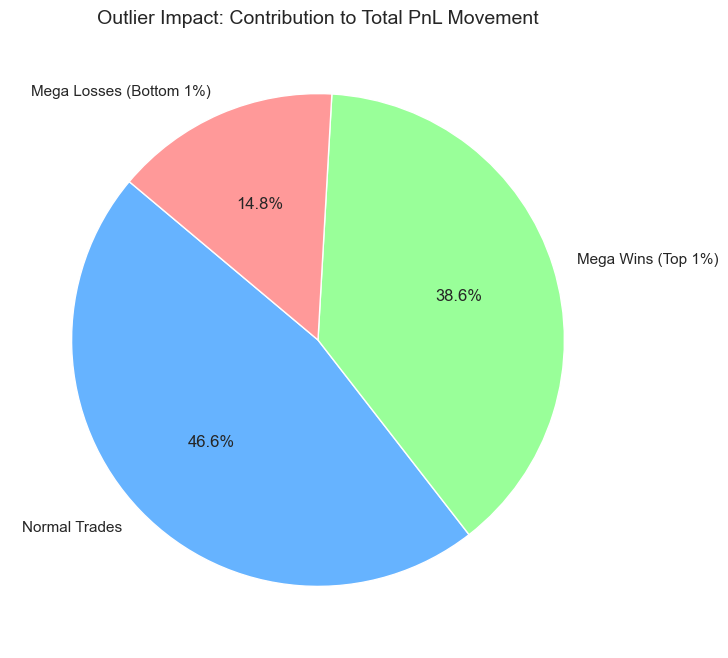

In [72]:
# VISUALIZATION: Contribution to Total Profit
plt.figure(figsize=(8, 8))
labels = ['Normal Trades', 'Mega Wins (Top 1%)', 'Mega Losses (Bottom 1%)']
# Use absolute values for the pie chart to show impact on movement
impact_sizes = [
    normal_trades['net_pnl'].sum(), 
    outlier_wins['net_pnl'].sum(), 
    abs(outlier_losses['net_pnl'].sum())
]
plt.pie(impact_sizes, labels=labels, autopct='%1.1f%%', colors=['#66b3ff','#99ff99','#ff9999'], startangle=140)
plt.title('Outlier Impact: Contribution to Total PnL Movement', fontsize=14)


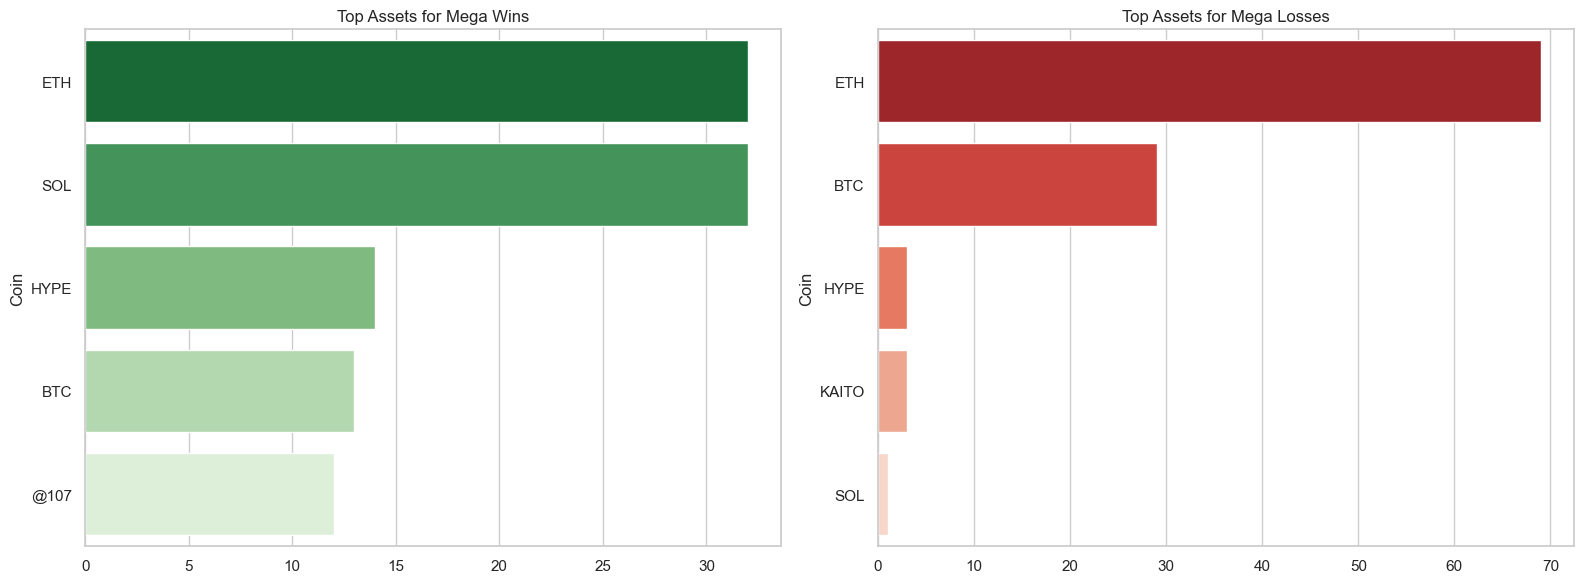

In [73]:
# VISUALIZATION: Asset Concentration in Outliers
win_coins = outlier_wins['Coin'].value_counts().head(5)
loss_coins = outlier_losses['Coin'].value_counts().head(5)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
sns.barplot(x=win_coins.values, y=win_coins.index, ax=ax1,hue=win_coins.index, legend=False,palette='Greens_r')
ax1.set_title('Top Assets for Mega Wins')
sns.barplot(x=loss_coins.values, y=loss_coins.index, ax=ax2,hue=loss_coins.index,legend=False,palette='Reds_r')
ax2.set_title('Top Assets for Mega Losses')
plt.tight_layout()

In [74]:
print(f"Strategic Insight: Top 1% of trades drive { (outlier_wins['net_pnl'].sum() / df['net_pnl'].sum() * 100):.1f}% of your total profit.")

Strategic Insight: Top 1% of trades drive 54.8% of your total profit.


In [75]:
# Largest win
max_win = df.loc[df['net_pnl'].idxmax()]
# Largest loss
max_loss = df.loc[df['net_pnl'].idxmin()]

print("Largest Win:")
print(max_win[['Account', 'Coin', 'Size USD', 'net_pnl', 'classification']])

print("\nLargest Loss:")
print(max_loss[['Account', 'Coin', 'Size USD', 'net_pnl', 'classification']])

Largest Win:
Account           0x083384f897ee0f19899168e3b1bec365f52a9012
Coin                                                     ETH
Size USD                                           292870.12
net_pnl                                        135299.803088
classification                                          fear
Name: 1729, dtype: object

Largest Loss:
Account           0x083384f897ee0f19899168e3b1bec365f52a9012
Coin                                                     ETH
Size USD                                           814524.17
net_pnl                                       -118071.556516
classification                                         greed
Name: 130, dtype: object


In [76]:
#Sraregy for top 1% profit

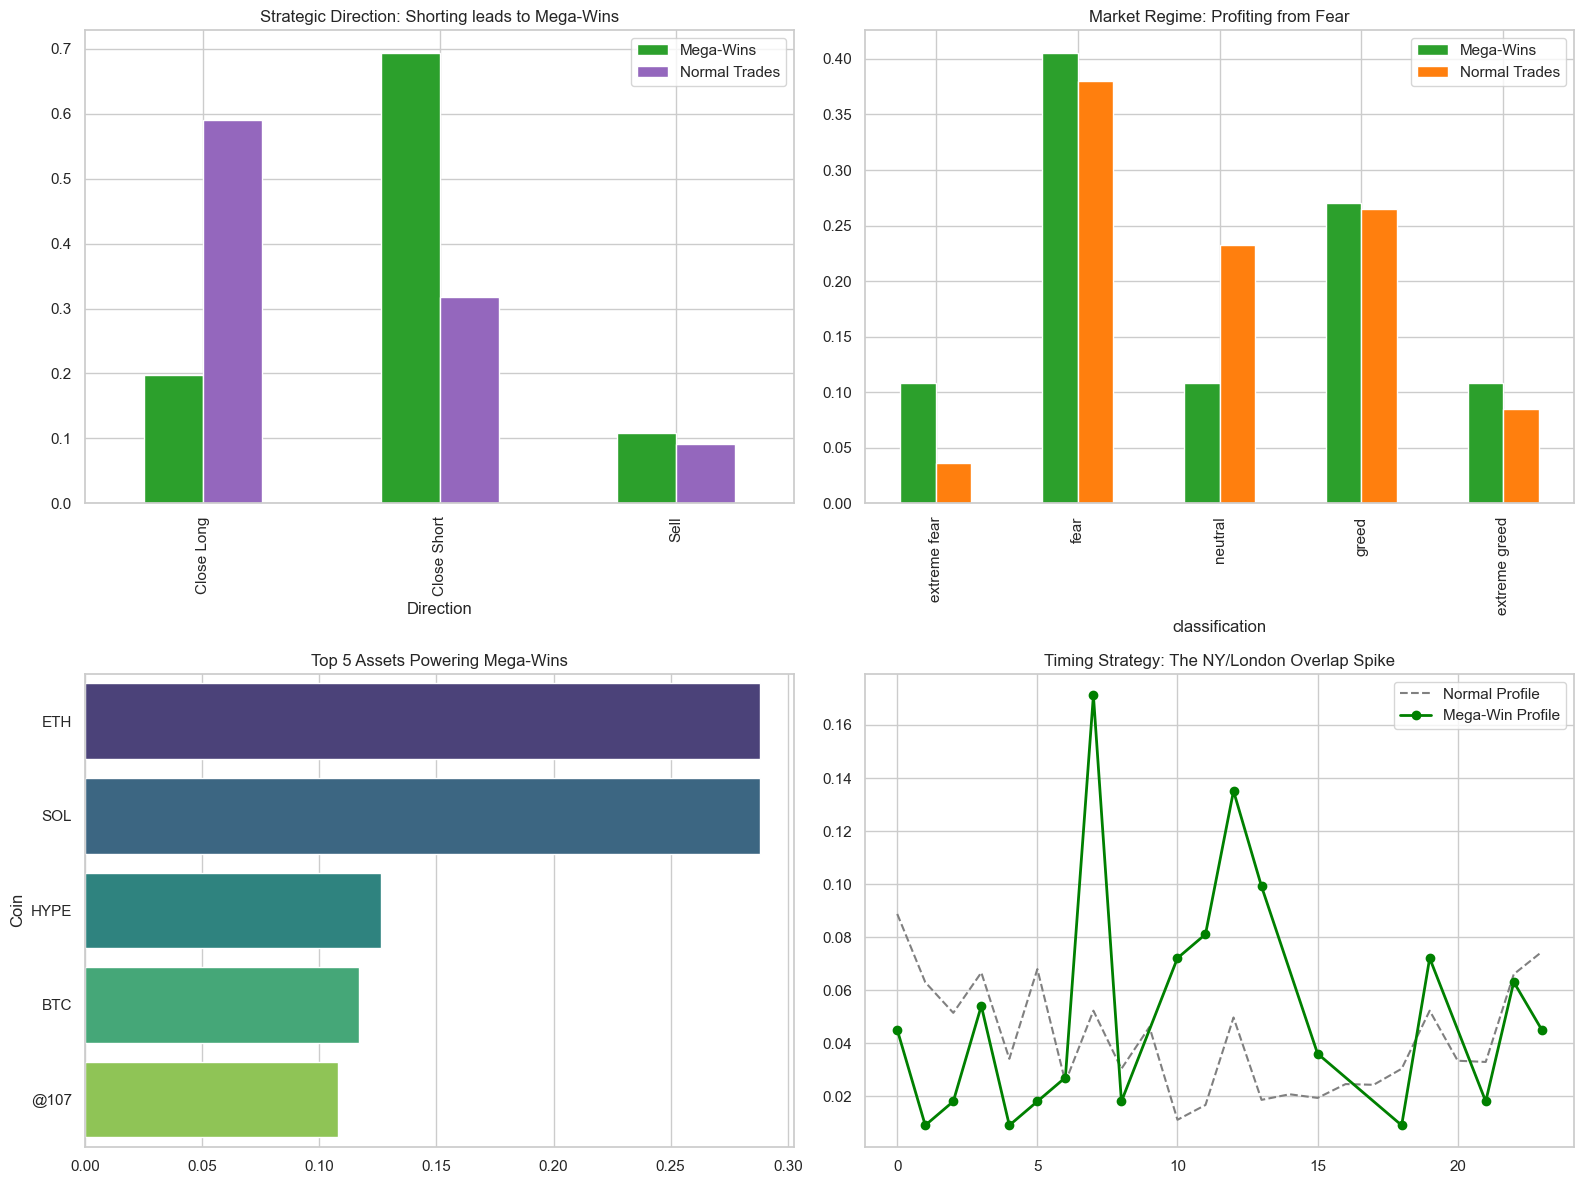

In [77]:
# Isolate the 'Mega-Wins' (Top 1%)
q_high = df['net_pnl'].quantile(0.99)
top_1_wins = df[df['net_pnl'] >= q_high].copy()
others = df[df['net_pnl'] < q_high].copy()

# Visualizing the Strategic Contrast
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
sns.set_theme(style="whitegrid")

# Strategy: Direction (Mega-Wins vs Others)
dir_data = pd.DataFrame({
    'Mega-Wins': top_1_wins['Direction'].value_counts(normalize=True),
    'Normal Trades': others['Direction'].value_counts(normalize=True)
}).fillna(0)
dir_data.plot(kind='bar', ax=axes[0, 0], color=['#2ca02c', '#9467bd'])
axes[0, 0].set_title('Strategic Direction: Shorting leads to Mega-Wins')

# Strategy: Sentiment Regime
sent_order = ['extreme fear', 'fear', 'neutral', 'greed', 'extreme greed']
sent_data = pd.DataFrame({
    'Mega-Wins': top_1_wins['classification'].value_counts(normalize=True),
    'Normal Trades': others['classification'].value_counts(normalize=True)
}).reindex(sent_order).fillna(0)
sent_data.plot(kind='bar', ax=axes[0, 1], color=['#2ca02c', '#ff7f0e'])
axes[0, 1].set_title('Market Regime: Profiting from Fear')

# Strategy: Asset Focus
coin_focus = top_1_wins['Coin'].value_counts(normalize=True).head(5)
sns.barplot(x=coin_focus.values, y=coin_focus.index,hue=coin_focus.index,legend=False, ax=axes[1, 0], palette='viridis')
axes[1, 0].set_title('Top 5 Assets Powering Mega-Wins')

# Strategy: Temporal Timing (Hourly UTC)
df['hour'] = pd.to_datetime(df['trade_time'], format='%H:%M:%S').dt.hour
hour_top = df[df['net_pnl'] >= q_high].groupby('hour').size() / len(top_1_wins)
hour_rest = df[df['net_pnl'] < q_high].groupby('hour').size() / len(others)

axes[1, 1].plot(hour_rest.index, hour_rest.values, label='Normal Profile', color='gray', linestyle='--')
axes[1, 1].plot(hour_top.index, hour_top.values, label='Mega-Win Profile', color='green', marker='o', linewidth=2)
axes[1, 1].set_title('Timing Strategy: The NY/London Overlap Spike')
axes[1, 1].legend()

plt.tight_layout()

                Strategy  Avg Net PnL  Win Rate
0         Baseline (All)   301.902742  0.878777
1   The Contrarian Short   779.056613  0.813459
2   Maker-Only Execution   476.135326  0.875747
3  NY Overlap Specialist   906.884664  0.903065
4    Blue-Chip High-Beta   556.471925  0.853228


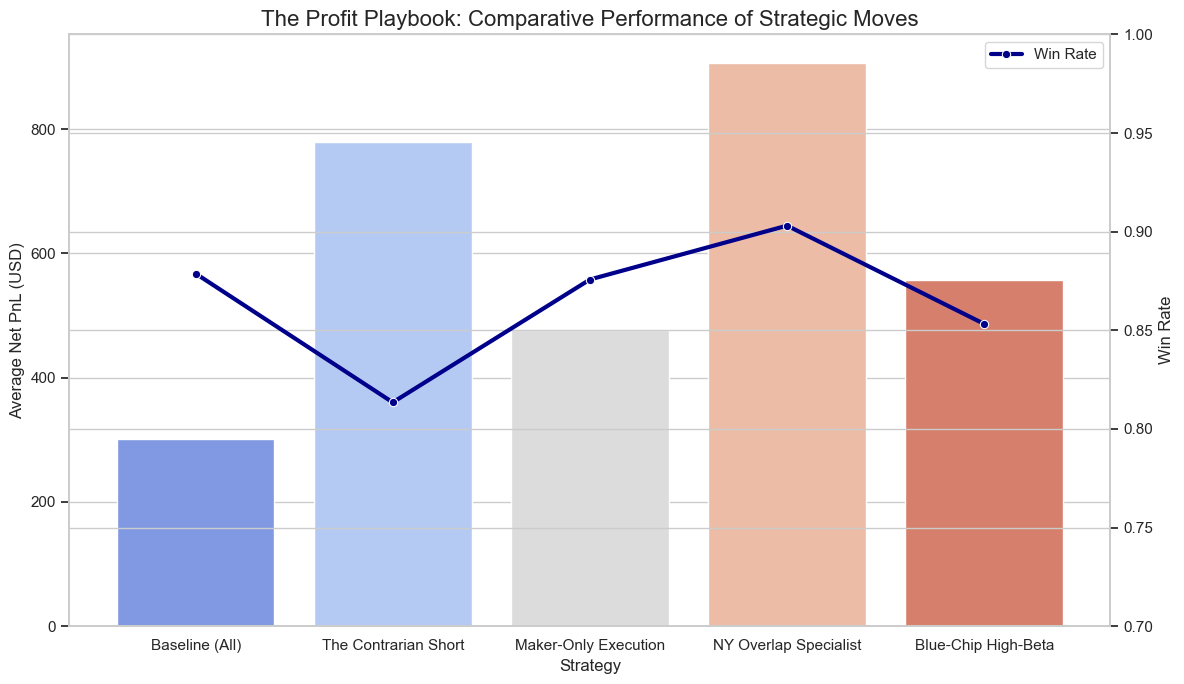

In [78]:
# Define Strategies
# The Contrarian Short (Close Short during Fear)
s1_mask = (df['Direction'] == 'Close Short') & (df['classification'].isin(['fear', 'extreme fear']))
s1_pnl = df[s1_mask]['net_pnl'].mean()
s1_wr = df[s1_mask]['is_win'].mean()

# Fee-Efficiency Master (Maker Only)
s2_mask = (df['Crossed'] == False)
s2_pnl = df[s2_mask]['net_pnl'].mean()
s2_wr = df[s2_mask]['is_win'].mean()

# The NY Overlap Specialist (Hour 11-15)
s3_mask = (df['hour'].between(11, 15))
s3_pnl = df[s3_mask]['net_pnl'].mean()
s3_wr = df[s3_mask]['is_win'].mean()

# Blue-Chip High-Beta (ETH & SOL only)
s4_mask = df['Coin'].isin(['ETH', 'SOL'])
s4_pnl = df[s4_mask]['net_pnl'].mean()
s4_wr = df[s4_mask]['is_win'].mean()

# Baseline
baseline_pnl = df['net_pnl'].mean()
baseline_wr = df['is_win'].mean()

# Combine results
strategies = pd.DataFrame({
    'Strategy': ['Baseline (All)', 'The Contrarian Short', 'Maker-Only Execution', 'NY Overlap Specialist', 'Blue-Chip High-Beta'],
    'Avg Net PnL': [baseline_pnl, s1_pnl, s2_pnl, s3_pnl, s4_pnl],
    'Win Rate': [baseline_wr, s1_wr, s2_wr, s3_wr, s4_wr]
})

# Plotting the "Profit Playbook"
sns.set_theme(style="whitegrid")
fig, ax1 = plt.subplots(figsize=(12, 7))

# Bar plot for PnL
sns.barplot(data=strategies, x='Strategy', y='Avg Net PnL',hue ='Strategy',legend=False, ax=ax1, palette='coolwarm')
ax1.set_ylabel('Average Net PnL (USD)', fontsize=12)
ax1.set_title('The Profit Playbook: Comparative Performance of Strategic Moves', fontsize=16)

# Line plot for Win Rate
ax2 = ax1.twinx()
sns.lineplot(data=strategies, x='Strategy', y='Win Rate', ax=ax2, color='darkblue', marker='o', linewidth=3, label='Win Rate')
ax2.set_ylabel('Win Rate', fontsize=12)
ax2.set_ylim(0.7, 1.0)

plt.xticks(rotation=15)
plt.tight_layout()

print(strategies)

Maker vs Taker Comparison:
                    Fee     net_pnl    is_win  Account
Crossed                                               
Maker (False)  0.608770  476.135326  0.875747     4016
Taker (True)   7.399634  202.014368  0.880514     7005


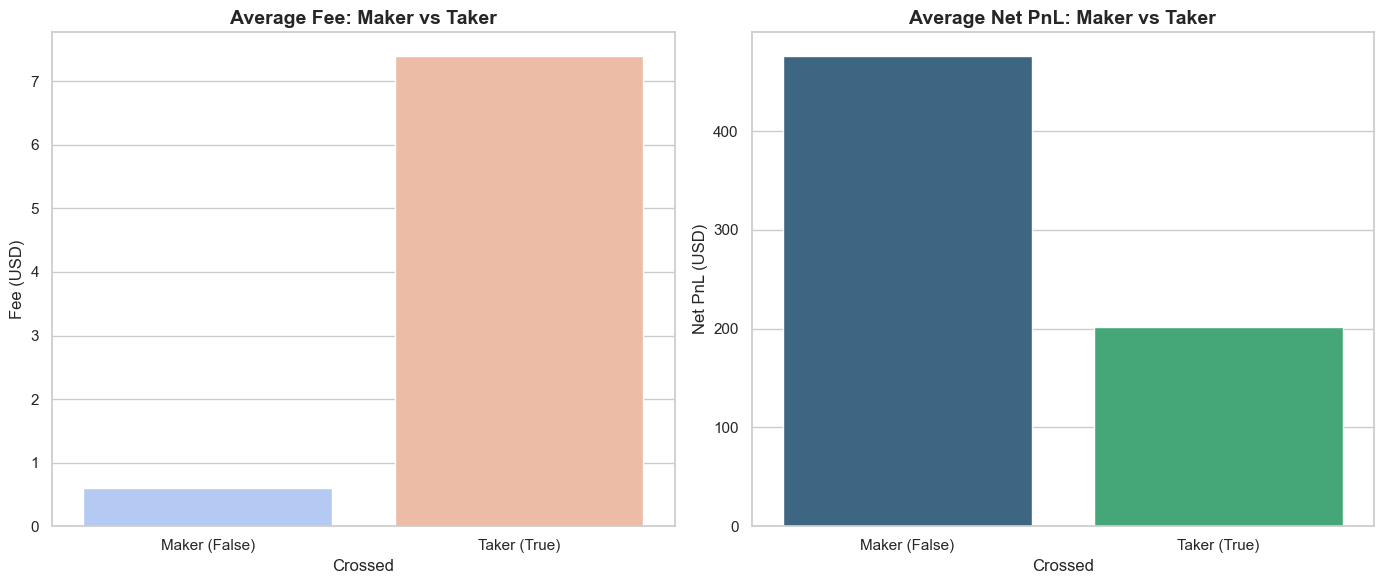

In [79]:
# Simple Aggregation to prove the point
maker_taker_stats = df.groupby('Crossed').agg({
    'Fee': 'mean',
    'net_pnl': 'mean',
    'is_win': 'mean',
    'Account': 'count'
}).rename(index={False: 'Maker (False)', True: 'Taker (True)'})

print("Maker vs Taker Comparison:")
print(maker_taker_stats)

# Visualization
sns.set_theme(style="whitegrid")
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Average Fee
sns.barplot(x=maker_taker_stats.index, y=maker_taker_stats['Fee'],hue=maker_taker_stats.index, legend=False, palette='coolwarm', ax=ax1)
ax1.set_title('Average Fee: Maker vs Taker', fontsize=14, fontweight='bold')
ax1.set_ylabel('Fee (USD)')

# Average Net PnL
sns.barplot(x=maker_taker_stats.index, y=maker_taker_stats['net_pnl'],hue=maker_taker_stats.index,legend=False, palette='viridis', ax=ax2)
ax2.set_title('Average Net PnL: Maker vs Taker', fontsize=14, fontweight='bold')
ax2.set_ylabel('Net PnL (USD)')

plt.tight_layout()
#plt.savefig('maker_vs_taker_visual.png')

  classification  is_win      Size USD       Fee   Crossed  Start Position
0   extreme fear   False   4831.455687  0.669203  0.293750   -19878.859246
1   extreme fear    True   9222.794223  1.243840  0.418327    -2990.445917
2           fear   False  32224.035356  6.636941  0.706406      294.331086
3           fear    True  30546.047141  4.971366  0.440650     2727.747146
4        neutral   False  25284.904328  6.573577  0.962687      786.686427
5        neutral    True  23105.511406  4.546046  0.837536     8132.484704
6          greed   False  31187.260409  6.955529  0.850000     -205.961215
7          greed    True  24178.231545  5.039999  0.660628    13305.124292
8  extreme greed   False  17964.501885  3.588615  0.296154     -696.215778
9  extreme greed    True  18875.499838  6.045343  0.957290      362.617606


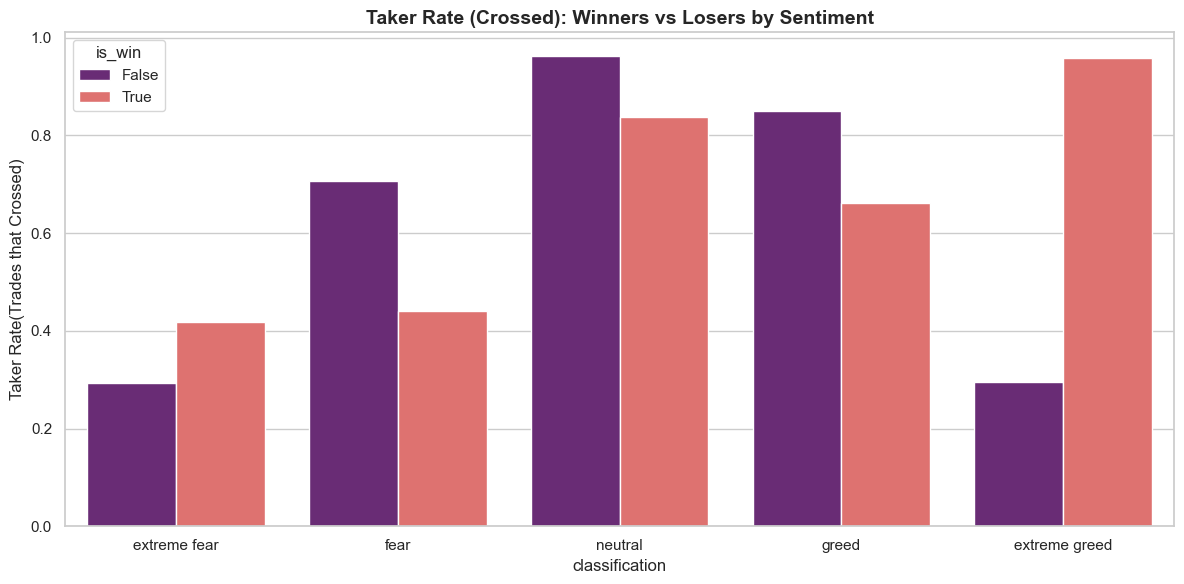

In [80]:
# Comparison of metrics: Winners vs Losers across Sentiment
# Let's create a dataframe to compare Size and Fee
loss_drivers = df.groupby(['classification', 'is_win'], observed=True).agg({
    'Size USD': 'mean',
    'Fee': 'mean',
    'Crossed': 'mean',
    'Start Position': 'mean'
}).reset_index()
print(loss_drivers)

# Visualizing Taker Rate (Crossed): Do urgent/market orders lead to losses?
plt.figure(figsize=(12, 6))
sns.barplot(data=loss_drivers, x='classification', y='Crossed', hue='is_win', palette='magma')
plt.title('Taker Rate (Crossed): Winners vs Losers by Sentiment', fontsize=14, fontweight='bold')
plt.ylabel('Taker Rate(Trades that Crossed)')
plt.tight_layout()

  classification  is_win      Size USD       Fee   Crossed  risk_adjusted_pnl
0   extreme fear   False   4831.455687  0.669203  0.293750          -0.199657
1   extreme fear    True   9222.794223  1.243840  0.418327           0.217773
2           fear   False  32224.035356  6.636941  0.706406          -0.050174
3           fear    True  30546.047141  4.971366  0.440650           0.059870
4        neutral   False  25284.904328  6.573577  0.962687          -0.032510
5        neutral    True  23105.511406  4.546046  0.837536           0.053893
6          greed   False  31187.260409  6.955529  0.850000          -0.046579
7          greed    True  24178.231545  5.039999  0.660628           0.072810
8  extreme greed   False  17964.501885  3.588615  0.296154          -0.033961
9  extreme greed    True  18875.499838  6.045343  0.957290           0.055027


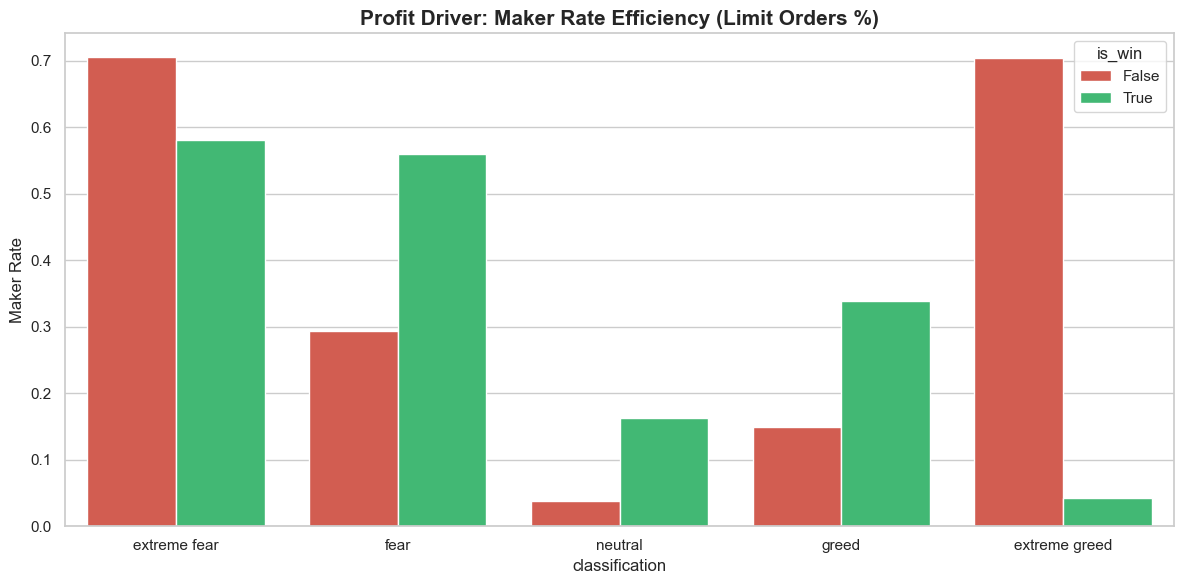

In [81]:
# Calculation: Alpha Traits of Winners (Profit Drivers)
# We want to see how Winners (is_win=True) differ from Losers (is_win=False)
profit_drivers = df.groupby(['classification', 'is_win'], observed=True).agg({
    'Size USD': 'mean',
    'Fee': 'mean',
    'Crossed': 'mean',  # Taker Rate
    'risk_adjusted_pnl': 'mean'
}).reset_index()
print(profit_drivers)

# Visualizing Execution Efficiency (Maker Rate = 1 - Taker Rate)
profit_drivers['maker_rate'] = (1 - profit_drivers['Crossed']) #* 100
plt.figure(figsize=(12, 6))
sns.barplot(data=profit_drivers, x='classification', y='maker_rate', hue='is_win', palette={True: '#2ecc71', False: '#e74c3c'})
plt.title('Profit Driver: Maker Rate Efficiency (Limit Orders %)', fontsize=15, fontweight='bold')
plt.ylabel('Maker Rate')
plt.tight_layout()